# Download all files for 2024 Year
# If you downloaded the files already , don't run this, Go Below!

📥 Downloading Daily NYC Subway Data (2024)

In this section, we download daily subway data files for all of 2024 from the official NYC subway data website.

* A folder named subway_data_2024 is created to store the files.
* The script loops through each day of the year, constructs the corresponding URL, and downloads the .tar.xz file if available.
* We include error handling for timeouts and failed requests, and add a 1-second pause between requests to avoid overloading the server.

In [ ]:
import requests
import os
from datetime import datetime, timedelta
import time

save_dir = "subway_data_2024"
os.makedirs(save_dir, exist_ok=True)

start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)

current_date = start_date
while current_date <= end_date:
    date_str = current_date.strftime("%Y-%m-%d")
    file_name = f"subwaydatanyc_{date_str}_csv.tar.xz"
    url = f"https://subwaydata.nyc/data/{file_name}"
    file_path = os.path.join(save_dir, file_name)

    print(f"Downloading {file_name}...")

    try:
        response = requests.get(url, timeout=15)  # 15 seconds timeout
        if response.status_code == 200:
            with open(file_path, "wb") as f:
                f.write(response.content)
        else:
            print(f"Failed to download {file_name}: HTTP {response.status_code}")
    except requests.exceptions.Timeout:
        print(f"Timeout occurred while downloading {file_name}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {file_name}: {e}")

    current_date += timedelta(days=1)
    time.sleep(1)  # wait a bit between requests to be polite to the server

🗃️ Extracting & Merging Daily Subway Files
This section extracts and combines daily .tar.xz files downloaded earlier:

* It loops through all compressed files and reads trips.csv and stop_times.csv from each archive.

* A date column is added to each dataset to track the file's origin.

* All individual files are concatenated into two master DataFrames: all_trips and all_stop_times.

Finally, both combined datasets are saved as CSVs in a designated folder



Data Acquisition & Preparation

In [ ]:
import os
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm

# Set paths
data_folder = r"C:\Users\ahmed.mabdullah\Desktop\GUC\Capstone Project\Subway_data\2024 Subway\subway_data_2024"

output_dir = os.path.join(data_folder, 'processed_data')

# Create output directory if needed
os.makedirs(output_dir, exist_ok=True)

# Initialize empty DataFrames
all_trips = pd.DataFrame()
all_stop_times = pd.DataFrame()

# Process files
tar_files = glob(os.path.join(data_folder, "*.tar.xz"))

for tar_file in tqdm(tar_files, desc="Processing files"):
    try:
        with tarfile.open(tar_file) as tar:
            members = tar.getnames()
            
            # Find and load files
            trips_data = pd.DataFrame()
            stop_times_data = pd.DataFrame()
            
            trips_file = next((m for m in members if 'trips.csv' in m), None)
            stop_times_file = next((m for m in members if 'stop_times.csv' in m), None)
            
            if trips_file:
                trips_data = pd.read_csv(tar.extractfile(trips_file))
            if stop_times_file:
                stop_times_data = pd.read_csv(tar.extractfile(stop_times_file))
            
            # Add date information
            date_str = os.path.basename(tar_file).split('_')[1]
            if not trips_data.empty:
                trips_data['date'] = date_str
            if not stop_times_data.empty:
                stop_times_data['date'] = date_str
                
            # Concatenate
            all_trips = pd.concat([all_trips, trips_data], ignore_index=True)
            all_stop_times = pd.concat([all_stop_times, stop_times_data], ignore_index=True)
    
    except Exception as e:
        print(f"Error processing {tar_file}: {str(e)}")
        continue

# Save with proper error handling
try:
    trips_path = os.path.join(output_dir, 'combined_trips.csv')
    stop_times_path = os.path.join(output_dir, 'combined_stop_times.csv')
    
    all_trips.to_csv(trips_path, index=False)
    all_stop_times.to_csv(stop_times_path, index=False)
    print(f"Files successfully saved to:\n{trips_path}\n{stop_times_path}")
    
except PermissionError:
    print("Permission denied in output directory. Trying fallback location...")
    fallback_dir = os.path.join(os.path.expanduser('~'), 'Documents', 'subway_data')
    os.makedirs(fallback_dir, exist_ok=True)
    
    trips_path = os.path.join(fallback_dir, 'combined_trips.csv')
    stop_times_path = os.path.join(fallback_dir, 'combined_stop_times.csv')
    
    all_trips.to_csv(trips_path, index=False)
    all_stop_times.to_csv(stop_times_path, index=False)
    print(f"Files saved to fallback location:\n{trips_path}\n{stop_times_path}")

🔄 Incremental Data Update: Process Only New Files
To avoid reprocessing already downloaded data, this section introduces a smart update mechanism:

* It first checks if previously combined CSV files (combined_trips.csv and combined_stop_times.csv) already exist.

* If found, it loads them and keeps track of which dates have been processed.

* It then scans all .tar.xz files and processes only the new ones based on the date in the filename.

* New data is appended to the existing DataFrames and saved again.

This approach speeds up updates and prevents redundant work.

In [ ]:
# To check for newly added .tar.xz files and merge only those not already processed, you can modify your code to:
# Track which files have already been processed.
# Load previously saved combined_trips.csv and combined_stop_times.csv if they exist.
# Only process new .tar.xz files, and append their content to the existing combined CSVs.

# --- Load already processed data if exists ---
processed_trips_path = os.path.join(output_dir, 'combined_trips.csv')
processed_stop_times_path = os.path.join(output_dir, 'combined_stop_times.csv')

if os.path.exists(processed_trips_path) and os.path.exists(processed_stop_times_path):
    print("Loading already processed data...")
    all_trips = pd.read_csv(processed_trips_path)
    all_stop_times = pd.read_csv(processed_stop_times_path)
    processed_dates = set(all_trips['date'].unique())
else:
    print("No previous combined files found. Starting fresh...")
    all_trips = pd.DataFrame()
    all_stop_times = pd.DataFrame()
    processed_dates = set()

# --- Re-scan all tar files ---
tar_files = glob(os.path.join(data_folder, "*.tar.xz"))

# --- Check for new files ---
new_files_found = False

for tar_file in tqdm(tar_files, desc="Checking for new files"):
    try:
        date_str = os.path.basename(tar_file).split('_')[1]

        if date_str in processed_dates:
            continue  # Skip already processed files

        new_files_found = True
        with tarfile.open(tar_file) as tar:
            members = tar.getnames()
            
            trips_file = next((m for m in members if 'trips.csv' in m), None)
            stop_times_file = next((m for m in members if 'stop_times.csv' in m), None)
            
            trips_data = pd.read_csv(tar.extractfile(trips_file)) if trips_file else pd.DataFrame()
            stop_times_data = pd.read_csv(tar.extractfile(stop_times_file)) if stop_times_file else pd.DataFrame()
            
            if not trips_data.empty:
                trips_data['date'] = date_str
                all_trips = pd.concat([all_trips, trips_data], ignore_index=True)
            if not stop_times_data.empty:
                stop_times_data['date'] = date_str
                all_stop_times = pd.concat([all_stop_times, stop_times_data], ignore_index=True)

    except Exception as e:
        print(f"Error reprocessing {tar_file}: {str(e)}")
        continue

# --- Save final updated files only if new files found ---
if new_files_found:
    try:
        all_trips.to_csv(processed_trips_path, index=False)
        all_stop_times.to_csv(processed_stop_times_path, index=False)
        print("New data added and files updated.")
    except PermissionError:
        fallback_dir = os.path.join(os.path.expanduser('~'), 'Documents', 'subway_data')
        os.makedirs(fallback_dir, exist_ok=True)
        all_trips.to_csv(os.path.join(fallback_dir, 'combined_trips.csv'), index=False)
        all_stop_times.to_csv(os.path.join(fallback_dir, 'combined_stop_times.csv'), index=False)
        print("Permission error. Files saved to fallback location.")
else:
    print("No new data found. Combined files remain unchanged.")


# If you already downloaded the files, Start from Here
# Before Sampling

🗺️ Mapping Stops to Boroughs (Chunked Merge)
This section adds borough information to the all_stop_times dataset using a lookup table:

* Loads a station lookup file (Lookup_StationsID_Borough.csv) that maps stop_id to boroughs.

* Reads the large combined_stop_times.csv in chunks to avoid memory issues.

* Each chunk is merged with the lookup table using stop_id as the key.

Finally, all merged chunks are combined into a full DataFrame.

In [ ]:
import pandas as pd

lookup_borough = pd.read_csv('C:/Users/ahmed.mabdullah/Desktop/GUC/Capstone Project/Subway_data/2024 Subway/subway_data_2024/processed_data/Lookup_StationsID_Borough.csv')

chunk_size = 1_000_000
chunks = pd.read_csv('C:/Users/ahmed.mabdullah/Desktop/GUC/Capstone Project/Subway_data/2024 Subway/subway_data_2024/processed_data/combined_stop_times.csv' , chunksize=chunk_size)
output_chunks = []

for chunk in chunks:
    # Optional: Convert key column to same dtype as lookup for merge
    chunk['stop_id'] = chunk['stop_id'].astype(lookup_borough['stop_id'].dtype)
    
    # Merge chunk with lookup
    merged_chunk = chunk.merge(lookup_borough, on='stop_id', how='left')
    
    output_chunks.append(merged_chunk)

# Concatenate all chunks after processing
all_stop_times= pd.concat(output_chunks, ignore_index=True)
all_stop_times.head(10)

In [ ]:
all_trips=pd.read_csv('C:/Users/ahmed.mabdullah/Desktop/GUC/Capstone Project/Subway_data/2024 Subway/subway_data_2024/processed_data/combined_trips.csv')

🎯 Stratified Sampling of Trip Data by Date
To make the dataset more manageable, this section creates a stratified sample of 625,000 trips:

* The total sampling fraction is calculated based on the desired size.

* The data is grouped by date to ensure the sample is evenly distributed across all days.

* Within each date group, a proportional random sample is selected (frac=fraction) using a fixed seed for reproducibility.

This approach preserves the temporal structure of the data while reducing its size.

In [ ]:
# Define the target sample size
target_total = 625_000

# Group by date to get the size per date
group_sizes = all_trips['date'].value_counts().sort_index()

# Calculate the sampling fraction for each group
fraction = target_total / len(all_trips)

# Stratified sample by date using groupby + sample
sampled_trips = (
    all_trips
    .groupby('date', group_keys=False)
    .apply(lambda x: x.sample(frac=fraction, random_state=42))
)

# Final check
print(f"Original size: {len(all_trips)}")
print(f"Sampled size: {len(sampled_trips)}")
print(sampled_trips['date'].value_counts())

sampled_trips.head()

🧹 Filtering Stop Times for Sampled Trips
After sampling 625,000 trips, this section filters the all_stop_times dataset to keep only the relevant rows:

* Extracts the unique trip_uids from the sampled_trips DataFrame.

* Processes the large all_stop_times dataset in chunks to manage memory efficiently.

* Each chunk is filtered to include only rows matching the sampled trip_uids.

Finally, all filtered chunks are combined into a single DataFrame (filtered_stops) for further analysis.

In [ ]:
import pandas as pd

# 1. Convert trip_ids to consistent type and get unique values
sampled_trip_ids = set(sampled_trips['trip_uid'].astype(str).unique())

# 3. Define chunk size and storage
chunk_size = 500_000  # You can adjust based on available RAM
n_rows = len(all_stop_times)
filtered_chunks = []

# 4. Process in chunks
for start in range(0, n_rows, chunk_size):
    end = min(start + chunk_size, n_rows)
    chunk = all_stop_times.iloc[start:end]
    
    # Filter this chunk
    filtered_chunk = chunk[chunk['trip_uid'].isin(sampled_trip_ids)]
    filtered_chunks.append(filtered_chunk)
    del chunk  # Free memory for next iteration

# 5. Combine filtered chunks
filtered_stops = pd.concat(filtered_chunks, ignore_index=True)

In [ ]:
#save sampled_trips into parquet file
sampled_trips.to_parquet('C:/Users/ahmed.mabdullah/Desktop/GUC/Capstone Project/Subway_data/2024 Subway/subway_data_2024/processed_data/sample_trips.parquet', index=False)
filtered_stops.to_parquet('C:/Users/ahmed.mabdullah/Desktop/GUC/Capstone Project/Subway_data/2024 Subway/subway_data_2024/processed_data/filtered_stops.parquet', index=False)

# If you have already and downloaded the parque files, start from here
# After Sampling

# Start from Here

🏁 Reloading Sampled Data from Parquet Files
If the data has already been sampled and saved, we can skip earlier steps and load directly from the saved Parquet files:

I did it to skip the previous steps in each run

* sample_trips.parquet: contains the stratified sample of 625,000 trips.

* filtered_stops.parquet: contains the stop times corresponding only to the sampled trips.

Using Parquet format ensures faster loading and efficient storage compared to CSV.

In [1]:
import pandas as pd
all_trips = pd.read_parquet('C:/Users/ahmed.mabdullah/Desktop/GUC/Capstone Project/Subway_data/2024 Subway/subway_data_2024/processed_data/sample_trips.parquet')
all_stop_times = pd.read_parquet('C:/Users/ahmed.mabdullah/Desktop/GUC/Capstone Project/Subway_data/2024 Subway/subway_data_2024/processed_data/filtered_stops.parquet')

# Overview and Summary Statistics about the datasets

In [2]:
from IPython.display import display

def heading(df, n=2):
    """Display the first n rows of a DataFrame as a table."""
    display(df.head(n))

# Show all tables below each other
heading(all_trips)
heading(all_stop_times)

,trip_uid,trip_id,route_id,direction_id,start_time,vehicle_id,last_observed,marked_past,num_updates,num_schedule_changes,num_schedule_rewrites,date
0,1704167460_N..S,023100_N..S,N,1,1704167460,1N 0350+ DIT/STL,1704189597,NaN,815,0,0,2024-01-01
1,1704110910_L..N,072850_L..N,L,0,1704110910,0L 1208+105/8AV,1704130732,1.704131e+09,480,0,0,2024-01-01


,trip_uid,stop_id,track,arrival_time,departure_time,last_observed,marked_past,date,Borough
0,1704085620_3..N42R,127N,2,NaN,1.704104e+09,1704102664,1.704103e+09,2024-01-01,Manhattan
1,1704085620_3..N42R,123N,3,1.704103e+09,1.704103e+09,1704102979,1.704103e+09,2024-01-01,Manhattan


In [3]:
#Some basic statistics about the datasets

from IPython.display import display

def df_summary(df, df_name='DataFrame'):
    print(f"\n{'='*80}")
    print(f"📊 Summary for: {df_name}")
    print(f"Shape: {df.shape}")

    num_cols = df.select_dtypes(include='number').columns.tolist()
    cat_cols = df.select_dtypes(include=['object', 'category', 'string']).columns.tolist()

    print("\n🔢 Numerical Columns:")
    print(num_cols)

    print("\n🔠 Categorical Columns:")
    print(cat_cols)

    print("\n📈 Describe (Numerical):")
    display(df.describe())


# Show all tables below each other
df_summary(all_trips)
df_summary(all_stop_times)


📊 Summary for: DataFrame
Shape: (625002, 12)

🔢 Numerical Columns:
['direction_id', 'start_time', 'last_observed', 'marked_past', 'num_updates', 'num_schedule_changes', 'num_schedule_rewrites']

🔠 Categorical Columns:
['trip_uid', 'trip_id', 'route_id', 'vehicle_id', 'date']

📈 Describe (Numerical):


,direction_id,start_time,last_observed,marked_past,num_updates,num_schedule_changes,num_schedule_rewrites
count,625002.000000,6.250020e+05,6.250020e+05,6.197150e+05,625002.000000,625002.000000,625002.000000
mean,0.507178,1.719783e+09,1.719802e+09,1.719807e+09,910.472474,0.059224,0.173959
std,0.499949,9.210962e+06,9.210932e+06,9.193112e+06,634.902910,1.605173,13.136152
min,0.000000,1.704085e+09,1.704083e+09,1.704083e+09,1.000000,-1.000000,0.000000
25%,0.000000,1.711701e+09,1.711719e+09,1.711749e+09,517.000000,0.000000,0.000000
50%,1.000000,1.719761e+09,1.719778e+09,1.719786e+09,778.000000,0.000000,0.000000
75%,1.000000,1.727853e+09,1.727870e+09,1.727838e+09,1177.000000,0.000000,0.000000
max,1.000000,1.735708e+09,1.735726e+09,1.735726e+09,17869.000000,436.000000,2590.000000



📊 Summary for: DataFrame
Shape: (16693630, 9)

🔢 Numerical Columns:
['arrival_time', 'departure_time', 'last_observed', 'marked_past']

🔠 Categorical Columns:
['trip_uid', 'stop_id', 'track', 'date', 'Borough']

📈 Describe (Numerical):


,arrival_time,departure_time,last_observed,marked_past
count,1.640514e+07,1.638808e+07,1.669363e+07,1.661805e+07
mean,1.719862e+09,1.719862e+09,1.719863e+09,1.719867e+09
std,9.196417e+06,9.196942e+06,9.196085e+06,9.181404e+06
min,1.704082e+09,1.704082e+09,1.704082e+09,1.704082e+09
25%,1.711849e+09,1.711848e+09,1.711850e+09,1.711900e+09
50%,1.719857e+09,1.719857e+09,1.719857e+09,1.719860e+09
75%,1.727893e+09,1.727894e+09,1.727893e+09,1.727881e+09
max,1.735730e+09,1.735730e+09,1.735726e+09,1.735726e+09


In [4]:
all_trips.info()
print(" #"*50)
all_trips.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625002 entries, 0 to 625001
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trip_uid               625002 non-null  object 
 1   trip_id                625002 non-null  object 
 2   route_id               625002 non-null  object 
 3   direction_id           625002 non-null  int64  
 4   start_time             625002 non-null  int64  
 5   vehicle_id             625002 non-null  object 
 6   last_observed          625002 non-null  int64  
 7   marked_past            619715 non-null  float64
 8   num_updates            625002 non-null  int64  
 9   num_schedule_changes   625002 non-null  int64  
 10  num_schedule_rewrites  625002 non-null  int64  
 11  date                   625002 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 57.2+ MB
 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

,trip_uid,trip_id,route_id,direction_id,start_time,vehicle_id,last_observed,marked_past,num_updates,num_schedule_changes,num_schedule_rewrites,date
0,1704167460_N..S,023100_N..S,N,1,1704167460,1N 0350+ DIT/STL,1704189597,NaN,815,0,0,2024-01-01
1,1704110910_L..N,072850_L..N,L,0,1704110910,0L 1208+105/8AV,1704130732,1.704131e+09,480,0,0,2024-01-01
2,1704106800_C..N,066000_C..N,C,0,1704106800,1C 1100 EUC/168,1704128795,1.704129e+09,1400,0,0,2024-01-01


🕒 Convert Timestamps to New York Time

* This step converts UNIX timestamps in all_trips to New York local time and removes timezone info for cleaner display.

* The date column is also simplified to contain only the date.

In [5]:
# Convert UNIX timestamps to datetime in New York timezone and remove timezone info in all_trips

# Step 1: Convert from UNIX time to UTC
# Step 2: Convert to New York local time
# Step 3: Remove timezone info for clean display

import pandas as pd

def convert_unix_to_local_time(all_trips: pd.DataFrame) -> pd.DataFrame:
    """
    Convert UNIX timestamps in 'all_trips' DataFrame to New York local time and remove timezone info.
    Also converts 'date' column to just the date part.
    
    Parameters:
        all_trips (pd.DataFrame): DataFrame with columns 'start_time', 'last_observed', 'marked_past', and 'date'.

    Returns:
        pd.DataFrame: Updated DataFrame with converted datetime columns.
    """
    # Convert UNIX time columns to datetime in New York timezone
    for col in ['start_time', 'last_observed', 'marked_past']:
        all_trips[col] = pd.to_datetime(all_trips[col], unit='s', utc=True)\
                            .dt.tz_convert('America/New_York')\
                            .dt.tz_localize(None)
    
    # Convert 'date' column to just the date (no time)
    all_trips['date'] = pd.to_datetime(all_trips['date']).dt.date

    # Optional: Uncomment the next line to preview results in testing
    # print(all_trips.head())

    return all_trips

# Example usage
all_trips = convert_unix_to_local_time(all_trips)

In [6]:
all_stop_times.info()
print(" #"*50)
all_stop_times.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16693630 entries, 0 to 16693629
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   trip_uid        object 
 1   stop_id         object 
 2   track           object 
 3   arrival_time    float64
 4   departure_time  float64
 5   last_observed   int64  
 6   marked_past     float64
 7   date            object 
 8   Borough         object 
dtypes: float64(3), int64(1), object(5)
memory usage: 1.1+ GB
 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


,trip_uid,stop_id,track,arrival_time,departure_time,last_observed,marked_past,date,Borough
0,1704085620_3..N42R,127N,2,NaN,1.704104e+09,1704102664,1.704103e+09,2024-01-01,Manhattan
1,1704085620_3..N42R,123N,3,1.704103e+09,1.704103e+09,1704102979,1.704103e+09,2024-01-01,Manhattan
2,1704085620_3..N42R,120N,3,1.704103e+09,1.704103e+09,1704102979,1.704103e+09,2024-01-01,Manhattan
3,1704085620_3..N42R,227N,3,1.704103e+09,1.704103e+09,1704102979,1.704103e+09,2024-01-01,Manhattan
4,1704085620_3..N42R,226N,3,1.704103e+09,1.704103e+09,1704102979,1.704103e+09,2024-01-01,Manhattan


🕒 Chunked Time Conversion for Stop Times

* This function converts UNIX timestamps in all_stop_times to New York time in chunks to handle large data efficiently (16,693,630 Rows)

* It also formats the date column to show only the date.

In [7]:
# Convert UNIX timestamps to datetime in New York timezone and remove timezone info in all_stop_times


def convert_chunked_unix_to_local_time(all_stop_times: pd.DataFrame, chunk_size: int = 350_000) -> pd.DataFrame:
    """
    Convert UNIX timestamp columns in chunks to New York local time, removing timezone info.
    Also converts the 'date' column to date only.

    Parameters:
        all_stop_times (pd.DataFrame): The DataFrame with UNIX timestamp columns.
        chunk_size (int): Number of rows per chunk for processing.

    Returns:
        pd.DataFrame: The updated DataFrame with converted datetime and date columns.
    """
    n_rows = len(all_stop_times)

    for start in range(0, n_rows, chunk_size):
        end = min(start + chunk_size, n_rows)
        chunk = all_stop_times.iloc[start:end]

        for col in ['arrival_time', 'departure_time', 'last_observed', 'marked_past']:
            all_stop_times.loc[start:end-1, col] = pd.to_datetime(chunk[col], unit='s', utc=True)\
                                                    .dt.tz_convert('America/New_York')\
                                                    .dt.tz_localize(None)

        all_stop_times.loc[start:end-1, 'date'] = pd.to_datetime(chunk['date']).dt.date

    # Optional preview
    # print(all_stop_times.head())

    return all_stop_times

all_stop_times = convert_chunked_unix_to_local_time(all_stop_times)

C:\Users\ahmed.mabdullah\AppData\Local\Temp\ipykernel_39988\723165391.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<DatetimeArray>
[                'NaT', '2024-01-01 04:54:34', '2024-01-01 04:57:04',
 '2024-01-01 05:01:04', '2024-01-01 05:02:04', '2024-01-01 05:03:34',
 '2024-01-01 05:05:04', '2024-01-01 05:07:04', '2024-01-01 05:12:04',
                 'NaT',
 ...
 '2024-01-08 09:47:22', '2024-01-08 09:48:37', '2024-01-08 09:51:02',
 '2024-01-08 09:53:07', '2024-01-08 09:55:17', '2024-01-08 09:56:52',
 '2024-01-08 09:59:05', '2024-01-08 10:00:12', '2024-01-08 10:01:52',
 '2024-01-08 10:03:42']
Length: 350000, dtype: datetime64[ns]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  all_stop_times.loc[start:end-1, col] = pd.to_datetime(chunk[col], unit='s', utc=True)\
C:\Users\ahmed.mabdullah\AppData\Local\Temp\ipykernel_39988\723165391.py:23: FutureWarni

In [8]:
#shape of the dataframes
print("Shape of all_trips DataFrame:", all_trips.shape)
print("Shape of all_stop_times DataFrame:", all_stop_times.shape)

Shape of all_trips DataFrame: (625002, 12)
Shape of all_stop_times DataFrame: (16693630, 9)


In [9]:
def heading(df, n=2):
    """Display the first n rows of a DataFrame as a table."""
    display(df.head(n))

# Show all tables below each other
heading(all_trips)
heading(all_stop_times)

,trip_uid,trip_id,route_id,direction_id,start_time,vehicle_id,last_observed,marked_past,num_updates,num_schedule_changes,num_schedule_rewrites,date
0,1704167460_N..S,023100_N..S,N,1,2024-01-01 22:51:00,1N 0350+ DIT/STL,2024-01-02 04:59:57,NaT,815,0,0,2024-01-01
1,1704110910_L..N,072850_L..N,L,0,2024-01-01 07:08:30,0L 1208+105/8AV,2024-01-01 12:38:52,2024-01-01 12:39:02,480,0,0,2024-01-01


,trip_uid,stop_id,track,arrival_time,departure_time,last_observed,marked_past,date,Borough
0,1704085620_3..N42R,127N,2,NaT,2024-01-01 05:07:00,2024-01-01 04:51:04,2024-01-01 04:51:08,2024-01-01,Manhattan
1,1704085620_3..N42R,123N,3,2024-01-01 04:54:34,2024-01-01 04:54:34,2024-01-01 04:56:19,2024-01-01 04:57:34,2024-01-01,Manhattan


💰 Add Fixed Fare per Trip

Each subway trip costs a flat $2.90, regardless of distance or transfers. This step adds a fare_per_trip column to reflect that consistent fare for every trip.

In [10]:
#✅ Key Rule: One fare = One trip, regardless of the number of stops
# The Fare of Trip = 2.90 $
# If your trip starts when you enter the subway system and ends when you exit, you pay only one fare ($2.90) — no matter how many stops or line changes you make within the system.
#You enter at Station A, make 5 stops, transfer lines, and exit at Station B — still just $2.90.

def add_fare_column(all_trips: pd.DataFrame, fare_per_trip: float = 2.90) -> pd.DataFrame:
    """
    Add a fixed fare per trip column to the DataFrame.

    Parameters:
        all_trips (pd.DataFrame): The DataFrame containing trip records.
        fare_per_trip (float): The fixed fare amount to assign to each trip.

    Returns:
        pd.DataFrame: Updated DataFrame with a 'fare_per_trip' column added.
    """
    all_trips['fare_per_trip'] = fare_per_trip
    
    # Optional: Preview the updated DataFrame
    # print(all_trips.head())
    
    return all_trips

all_trips = add_fare_column(all_trips)

🕳️ Missing Data Overview

This step summarizes and visualizes missing values in all_trips and all_stop_times:

* Displays counts and percentages of missing values per column.

* Optionally shows a Missingno matrix plot to identify patterns.

* Helps decide whether imputation or cleaning is needed.


🕳️ Missing Value Summary for: all_trips


,Missing Count,Missing %
marked_past,5287,0.85



📊 Missingno Matrix Plot:


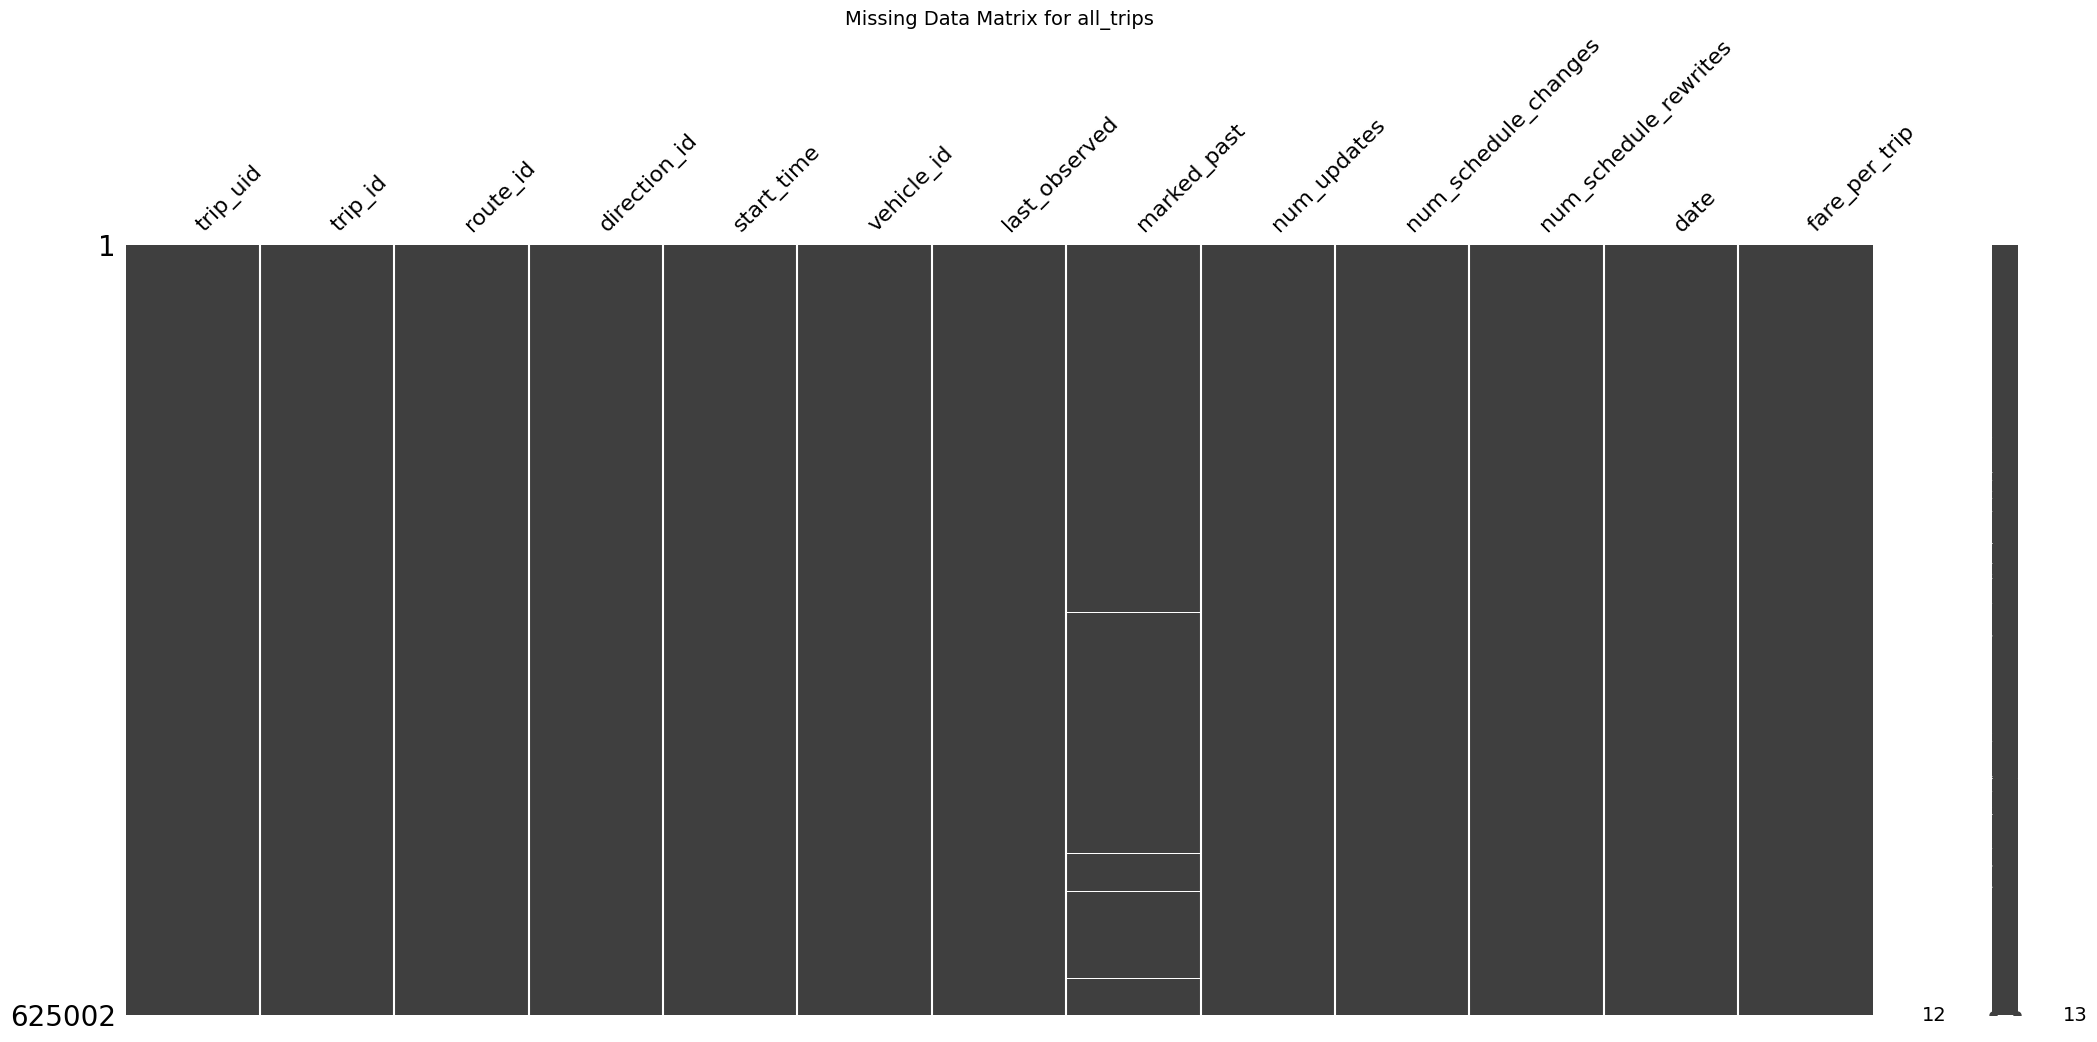


🕳️ Missing Value Summary for: all_stop_times


,Missing Count,Missing %
departure_time,305552,1.83
arrival_time,288490,1.73
marked_past,75582,0.45
track,6508,0.04



📊 Missingno Matrix Plot:


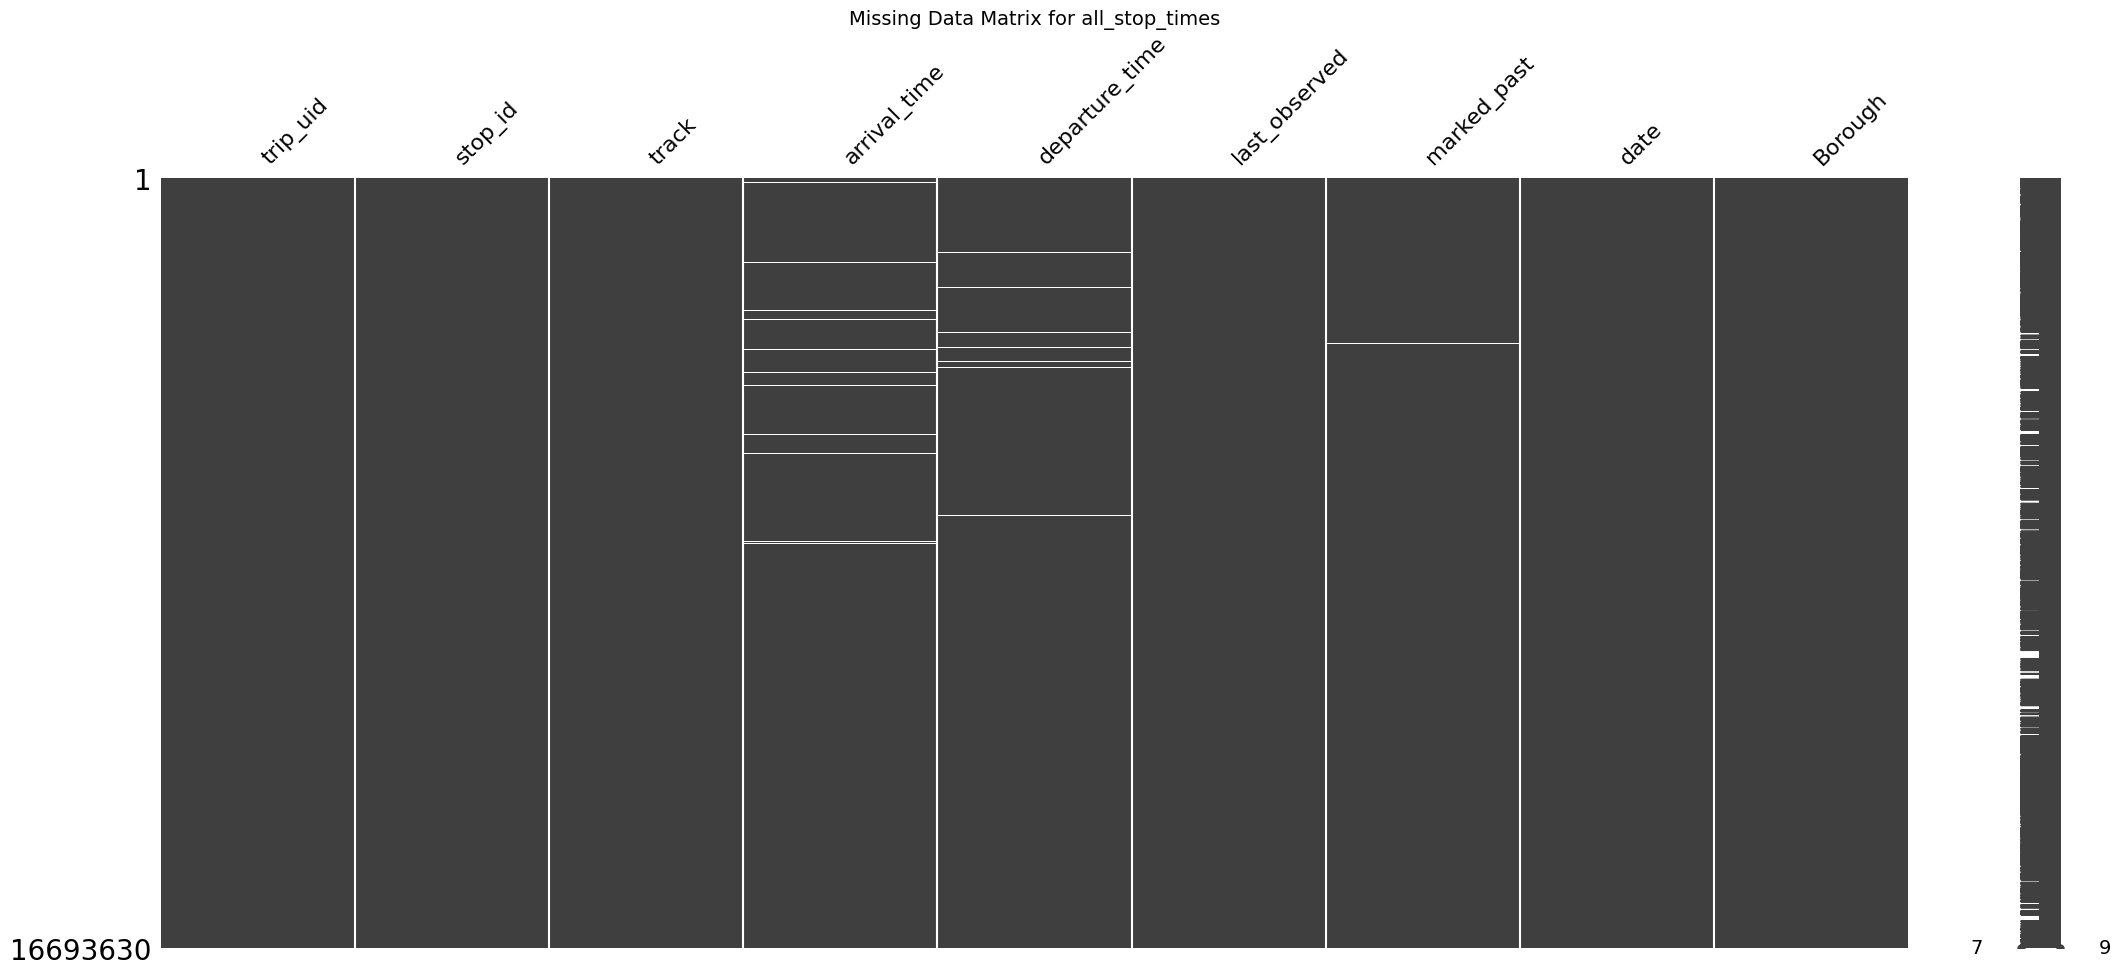

,Missing Count,Missing %
departure_time,305552,1.83
arrival_time,288490,1.73
marked_past,75582,0.45
track,6508,0.04


In [11]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

def missing_summary(df: pd.DataFrame, df_name: str = 'DataFrame', plot: bool = False) -> pd.DataFrame:
    """
    Display a summary of missing values in the DataFrame, optionally with a missingno matrix plot.

    Parameters:
        df (pd.DataFrame): The DataFrame to inspect.
        df_name (str): Name of the DataFrame (used for display purposes).
        plot (bool): If True, show a missingno matrix plot.

    Returns:
        pd.DataFrame: A DataFrame summarizing missing counts and percentages (or None if no missing).
    """
    print(f"\n{'='*80}")
    print(f"🕳️ Missing Value Summary for: {df_name}")
    
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    
    if missing.empty:
        print("✅ No missing values.")
        return None

    missing_percent = (missing / len(df)) * 100
    summary = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': missing_percent.round(2)
    }).sort_values(by='Missing %', ascending=False)

    display(summary)

    if plot:
        print("\n📊 Missingno Matrix Plot:")
        msno.matrix(df)
        plt.title(f"Missing Data Matrix for {df_name}", fontsize=14)
        plt.show()

    return summary

missing_summary(all_trips, 'all_trips', plot=True)
missing_summary(all_stop_times, 'all_stop_times', plot=True)

🔍 Check for Missing Arrival or Departure Times
This step identifies rows in all_stop_times where arrival_time or departure_time is missing:

* Filters affected rows and groups them by stop_id.

* Counts how many times each stop has missing time data.

* **No clear relationship** was found between the missing values and the observed data — the missingness appears random.

In [12]:
# Rows where arrival_time or departure_time is null
missing_times_df = all_stop_times[
    all_stop_times['arrival_time'].isnull() | all_stop_times['departure_time'].isnull()
]

# Group by stop_id and count how many missing entries per stop
grouped_missing = (
    missing_times_df
    .groupby('stop_id')
    .size()
    .reset_index(name='missing_count')
    .sort_values(by='missing_count', ascending=False)  # Sort descending
)

# Display the result
print(grouped_missing)

    stop_id  missing_count
178    726S          21325
137    640S          21025
177    726N          20773
138    701N          20423
139    701S          20332
..      ...            ...
109    503S              1
151    711N              1
120    616S              1
125    625S              1
132    633S              1

[231 rows x 2 columns]


🚫 Stops Missing Both Arrival and Departure Times
This step filters all_stop_times for rows where both arrival_time and departure_time are missing:

* Groups the results by stop_id to count affected entries.

* Observation: A significant portion of missing entries come from route L, indicating that this line may have issues with sensors or data collection devices. This suggests a need for improvement in their observation infrastructure.

In [13]:
# Rows where both arrival_time and departure_time are null
missing_both_times_df = all_stop_times[
    all_stop_times['arrival_time'].isnull() & all_stop_times['departure_time'].isnull()
]

# Group by stop_id and count how many missing entries per stop, then sort descending
grouped_missing_both = (
    missing_both_times_df
    .groupby('stop_id')
    .size()
    .reset_index(name='missing_count')
    .sort_values(by='missing_count', ascending=False)
)

# Display the result
print(grouped_missing_both)

   stop_id  missing_count
4     L03N             52
0     L01N             21
13    L10S             21
46    L29N             18
14    L11N             14
8     L06N             12
28    L19N             11
36    L24N             11
25    L16S             10
6     L05N             10
45    L28S             10
33    L21S             10
20    L14N              9
44    L28N              7
42    L27N              7
37    L24S              6
47    L29S              6
29    L19S              6
41    L26S              5
12    L10N              5
26    L17N              5
18    L13N              5
22    L15N              5
27    L17S              5
1     L01S              4
32    L21N              4
34    L22N              4
16    L12N              4
24    L16N              4
3     L02S              4
5     L03S              4
9     L06S              4
19    L13S              4
43    L27S              3
11    L08S              3
7     L05S              3
2     L02N              3
40    L26N  

🧼 Data Cleaning: Fix Missing Timestamps
This step performs key cleaning operations on both all_trips and all_stop_times:

* Fills missing marked_past values using last_observed.

* Fills missing arrival_time with departure_time and vice versa.

* Uses chunked processing to handle large datasets efficiently.

This ensures that time fields are complete and reliable for analysis.

In [14]:
def clean_and_filter_trips(all_trips: pd.DataFrame, all_stop_times: pd.DataFrame, chunk_size: int = 500_000) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    - Fill missing values in 'marked_past' using 'last_observed' in both DataFrames.
    - Fill missing 'arrival_time' with 'departure_time' and vice versa.
    - Drop rows in 'all_stop_times' where both 'arrival_time' and 'departure_time' are missing.

    Parameters:
        all_trips (pd.DataFrame): DataFrame with 'marked_past' and 'last_observed'.
        all_stop_times (pd.DataFrame): DataFrame with 'marked_past', 'last_observed', 'arrival_time', and 'departure_time'.
        chunk_size (int): Number of rows per chunk to process for filtering.

    Returns:
        tuple: (cleaned_all_trips, cleaned_all_stop_times)
    """

    # Fill missing values in 'marked_past'
    all_trips['marked_past'] = all_trips['marked_past'].fillna(all_trips['last_observed'])
    all_stop_times['marked_past'] = all_stop_times['marked_past'].fillna(all_stop_times['last_observed'])

    # Fill missing arrival_time or departure_time using the other
    all_stop_times['arrival_time'] = all_stop_times['arrival_time'].fillna(all_stop_times['departure_time'])
    all_stop_times['departure_time'] = all_stop_times['departure_time'].fillna(all_stop_times['arrival_time'])

    # Drop rows where both are still missing (rare case)
    n = len(all_stop_times)
    filtered_chunks = []

    for i in range(0, n, chunk_size):
        chunk = all_stop_times.iloc[i:i + chunk_size]
        filtered_chunk = chunk[chunk['departure_time'].notna() & chunk['arrival_time'].notna()]
        filtered_chunks.append(filtered_chunk)

    all_stop_times = pd.concat(filtered_chunks, ignore_index=True)

    return all_trips, all_stop_times

# Apply the function
all_trips, all_stop_times = clean_and_filter_trips(all_trips, all_stop_times)

C:\Users\ahmed.mabdullah\AppData\Local\Temp\ipykernel_39988\2333837898.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_stop_times['marked_past'] = all_stop_times['marked_past'].fillna(all_stop_times['last_observed'])
C:\Users\ahmed.mabdullah\AppData\Local\Temp\ipykernel_39988\2333837898.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_stop_times['arrival_time'] = all_stop_times['arrival_time'].fillna(all_stop_times['departure_time'])
C:\Users\ahmed.mabdullah\AppData\Local\Temp\ipykernel_39988\2333837898.py:22: FutureWarning: Downcasting 

🚉 Fill Missing Track Values by Stop
This step fills missing values in the **track column**:

* For each stop_id, missing track values are filled using the most common value (mode) at that stop.

In [15]:
def fill_missing_track_with_mode(all_stop_times: pd.DataFrame) -> pd.DataFrame:
    """
    Fill missing 'track' values in the DataFrame using the mode of each 'stop_id' group.

    Parameters:
        all_stop_times (pd.DataFrame): DataFrame containing 'stop_id' and 'track' columns.

    Returns:
        pd.DataFrame: Updated DataFrame with missing 'track' values filled.
    """
    all_stop_times['track'] = all_stop_times.groupby('stop_id')['track']\
        .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else None))
    
    return all_stop_times

all_stop_times = fill_missing_track_with_mode(all_stop_times)

🔁 Duplicate Rows Check
This step checks for fully duplicated rows in both all_trips and all_stop_times:

* Calculates the total number and percentage of duplicate rows.

* ✅ No duplicate rows were found in either dataset — ensuring data uniqueness and integrity.

In [16]:
# Check for duplicates

def duplicate_summary(df, df_name='DataFrame'):
    print(f"\n{'='*80}")
    print(f"🧾 Duplicate Rows Summary for: {df_name}")
    
    total_rows = len(df)
    dup_count = df.duplicated().sum()
    dup_percent = (dup_count / total_rows) * 100 if total_rows else 0

    if dup_count == 0:
        print("✅ No duplicate rows found.")
    else:
        print(f"❗ Duplicate Rows: {dup_count} / {total_rows} ({dup_percent:.2f}%)")

duplicate_summary(all_trips, 'all_trips')
duplicate_summary(all_stop_times, 'all_stop_times')


🧾 Duplicate Rows Summary for: all_trips
✅ No duplicate rows found.

🧾 Duplicate Rows Summary for: all_stop_times
✅ No duplicate rows found.


📉 Missing Values (%) in all_trips

This step calculates the percentage of missing values in each column of all_trips.

In [17]:
#check for missing values in all_trips and all_stop_times
all_trips.isnull().mean()*100

trip_uid                 0.0
trip_id                  0.0
route_id                 0.0
direction_id             0.0
start_time               0.0
vehicle_id               0.0
last_observed            0.0
marked_past              0.0
num_updates              0.0
num_schedule_changes     0.0
num_schedule_rewrites    0.0
date                     0.0
fare_per_trip            0.0
dtype: float64

📉 Missing Values (%) in all_stop_times

This step calculates the percentage of missing values in each column of all_stop_times.

In [18]:
#check for missing values in all_trips and all_stop_times
all_stop_times.isnull().mean()*100

trip_uid          0.0
stop_id           0.0
track             0.0
arrival_time      0.0
departure_time    0.0
last_observed     0.0
marked_past       0.0
date              0.0
Borough           0.0
dtype: float64

👁️ Data Preview

* This step displays the first few rows of the cleaned all_trips and all_stop_times DataFrames to verify that the data looks correct after all preprocessing steps.

In [19]:
from IPython.display import display

def heading(df, n=2):
    """Display the first n rows of a DataFrame as a table."""
    display(df.head(n))

# Show all tables below each other
heading(all_trips)
heading(all_stop_times)

,trip_uid,trip_id,route_id,direction_id,start_time,vehicle_id,last_observed,marked_past,num_updates,num_schedule_changes,num_schedule_rewrites,date,fare_per_trip
0,1704167460_N..S,023100_N..S,N,1,2024-01-01 22:51:00,1N 0350+ DIT/STL,2024-01-02 04:59:57,2024-01-02 04:59:57,815,0,0,2024-01-01,2.9
1,1704110910_L..N,072850_L..N,L,0,2024-01-01 07:08:30,0L 1208+105/8AV,2024-01-01 12:38:52,2024-01-01 12:39:02,480,0,0,2024-01-01,2.9


,trip_uid,stop_id,track,arrival_time,departure_time,last_observed,marked_past,date,Borough
0,1704085620_3..N42R,127N,2,2024-01-01 05:07:00,2024-01-01 05:07:00,2024-01-01 04:51:04,2024-01-01 04:51:08,2024-01-01,Manhattan
1,1704085620_3..N42R,123N,3,2024-01-01 04:54:34,2024-01-01 04:54:34,2024-01-01 04:56:19,2024-01-01 04:57:34,2024-01-01,Manhattan


⏱️ Add and Clean Stop Duration
This step calculates how long a subway stays at each stop:

* Computes stop_duration_seconds as the difference between departure_time and arrival_time.

* Replaces invalid values (e.g. negative, zero, or missing durations) with the overall average stop duration for consistency.

* Ensures all stop durations are realistic and usable for analysis.

In [20]:
def calculate_stop_duration_seconds_v2(df: pd.DataFrame) -> pd.DataFrame:
    """
    Alternative function to calculate 'stop_duration_seconds'.
    Converts time columns to datetime only once using pandas chaining,
    then computes the duration in seconds.
    """
    # Convert both columns at once (creates new columns, then assign back)
    df[['arrival_time', 'departure_time']] = df[['arrival_time', 'departure_time']].apply(
        pd.to_datetime, errors='coerce'
    )

    # Calculate stop duration in seconds
    df['stop_duration_seconds'] = (df['departure_time'] - df['arrival_time']).dt.total_seconds()

    return df

# Usage
all_stop_times = calculate_stop_duration_seconds_v2(all_stop_times)

In [21]:
def impute_zero_stop_duration_with_mean(df: pd.DataFrame) -> pd.DataFrame:
    """
    Replace stop_duration_seconds values equal to 0 with
    the mean of all positive stop_duration_seconds values.
    """
    # Calculate mean of positive durations only
    positive_mean = df.loc[df['stop_duration_seconds'] > 0, 'stop_duration_seconds'].mean()

    # Replace zeros with the mean
    zero_mask = df['stop_duration_seconds'] == 0
    df.loc[zero_mask, 'stop_duration_seconds'] = positive_mean

    return df
all_stop_times = impute_zero_stop_duration_with_mean(all_stop_times)

🚆 Calculate Trip Duration in Hours
This step adds a new column trip_duration_hours to all_trips:

* Calculates the trip duration as the time between the first arrival and last departure for each trip_uid using all_stop_times.

* Converts the duration to hours.

* Uses an optimized approach to minimize memory usage during the merge.

In [22]:
def add_trip_duration_merge(all_trips: pd.DataFrame, all_stop_times: pd.DataFrame) -> pd.DataFrame:
    # Ensure datetime
    for col in ['arrival_time', 'departure_time']:
        all_stop_times[col] = pd.to_datetime(all_stop_times[col], errors='coerce')

    # Compute min arrival and max departure per trip
    agg_times = all_stop_times.groupby('trip_uid').agg({
        'arrival_time': 'min',
        'departure_time': 'max'
    }).reset_index()

    agg_times['trip_duration_hours'] = (
        (agg_times['departure_time'] - agg_times['arrival_time']).dt.total_seconds() / 3600
    )

    # Merge back to all_trips
    return all_trips.merge(agg_times[['trip_uid', 'trip_duration_hours']], on='trip_uid', how='left')

# Apply the function
all_trips = add_trip_duration_merge(all_trips, all_stop_times)

👁️ Data Preview

* This step displays the first few rows of the cleaned all_trips and all_stop_times DataFrames to verify that the data looks correct after all preprocessing steps.

In [23]:
#all_trips and all_stop_times head
from IPython.display import display

# Show both DataFrames
display(all_trips.head())
display(all_stop_times.head())

,trip_uid,trip_id,route_id,direction_id,start_time,vehicle_id,last_observed,marked_past,num_updates,num_schedule_changes,num_schedule_rewrites,date,fare_per_trip,trip_duration_hours
0,1704167460_N..S,023100_N..S,N,1,2024-01-01 22:51:00,1N 0350+ DIT/STL,2024-01-02 04:59:57,2024-01-02 04:59:57,815,0,0,2024-01-01,2.9,1.221111
1,1704110910_L..N,072850_L..N,L,0,2024-01-01 07:08:30,0L 1208+105/8AV,2024-01-01 12:38:52,2024-01-01 12:39:02,480,0,0,2024-01-01,2.9,0.533611
2,1704106800_C..N,066000_C..N,C,0,2024-01-01 06:00:00,1C 1100 EUC/168,2024-01-01 12:06:35,2024-01-01 12:06:45,1400,0,0,2024-01-01,2.9,1.098611
3,1704115440_L..S,080400_L..S,L,1,2024-01-01 08:24:00,0L 1324 8AV/RPY,2024-01-01 13:57:52,2024-01-01 13:58:02,512,0,0,2024-01-01,2.9,0.557500
4,1704155130_1..S03R,002550_1..S03R,1,1,2024-01-01 19:25:30,01 0025+ 242/SFT,2024-01-02 01:34:22,2024-01-02 01:34:26,601,0,0,2024-01-01,2.9,1.131111


,trip_uid,stop_id,track,arrival_time,departure_time,last_observed,marked_past,date,Borough,stop_duration_seconds
0,1704085620_3..N42R,127N,2,2024-01-01 05:07:00,2024-01-01 05:07:00,2024-01-01 04:51:04,2024-01-01 04:51:08,2024-01-01,Manhattan,32.413434
1,1704085620_3..N42R,123N,3,2024-01-01 04:54:34,2024-01-01 04:54:34,2024-01-01 04:56:19,2024-01-01 04:57:34,2024-01-01,Manhattan,32.413434
2,1704085620_3..N42R,120N,3,2024-01-01 04:57:04,2024-01-01 04:57:04,2024-01-01 04:56:19,2024-01-01 04:57:34,2024-01-01,Manhattan,32.413434
3,1704085620_3..N42R,227N,3,2024-01-01 05:01:04,2024-01-01 05:01:04,2024-01-01 04:56:19,2024-01-01 04:57:34,2024-01-01,Manhattan,32.413434
4,1704085620_3..N42R,226N,3,2024-01-01 05:02:04,2024-01-01 05:02:04,2024-01-01 04:56:19,2024-01-01 04:57:34,2024-01-01,Manhattan,32.413434


📉 Outlier Detection with IQR Method
This step checks for numerical outliers in both all_trips and all_stop_times using the Interquartile Range (IQR) method:

* Flags values that fall outside 1.5×IQR from the 25th and 75th percentiles.

* Reports the number and percentage of outliers per column.

* Helps identify unusual or potentially problematic values that may need investigation or cleaning.

* **Observation**: Outliers were found in both trip_duration_hours and stop_duration_seconds, indicating some trips or stops have unusually long durations that may need further review.

In [24]:
#Outliers

def outlier_summary(df, df_name='DataFrame', iqr_multiplier=1.5):
    print(f"\n{'='*80}")
    print(f"📉 Outlier Summary for: {df_name}")
    
    num_cols = df.select_dtypes(include='number').columns
    if len(num_cols) == 0:
        print("⚠️ No numerical columns to check for outliers.")
        return
    
    outlier_report = []

    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        
        if outlier_count > 0:
            outlier_report.append({
                'Column': col,
                'Outlier Count': outlier_count,
                'Outlier %': round(100 * outlier_count / len(df), 2),
                'Min': df[col].min(),
                'Max': df[col].max()
            })

    if not outlier_report:
        print("✅ No outliers found using the IQR method.")
    else:
        outlier_df = pd.DataFrame(outlier_report).sort_values(by='Outlier Count', ascending=False)
        display(outlier_df)

outlier_summary(all_trips, 'all_trips')
outlier_summary(all_stop_times, 'all_stop_times')


📉 Outlier Summary for: all_trips


,Column,Outlier Count,Outlier %,Min,Max
0,num_updates,22980,3.68,1.0,17869.000000
1,num_schedule_changes,19189,3.07,-1.0,436.000000
2,num_schedule_rewrites,4192,0.67,0.0,2590.000000
3,trip_duration_hours,773,0.12,0.0,25.975278



📉 Outlier Summary for: all_stop_times


,Column,Outlier Count,Outlier %,Min,Max
0,stop_duration_seconds,1815698,10.88,-60.0,3840.0


🚨 Extract and Sort Duration Outliers
This step identifies and displays outlier rows for durations using the IQR method:

* Retrieves rows with unusually high or low values in trip_duration_hours and stop_duration_seconds.

* Sorts them descendingly to highlight the most extreme outliers first.

* After reviewing these outliers, no clear pattern or relationship was found, so we decided to keep them in the dataset for now.

In [25]:
def get_outlier_rows(df, column, iqr_multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Get and sort outliers for 'trip_duration_hours' in all_trips
trip_duration_outliers = get_outlier_rows(all_trips, 'trip_duration_hours')\
    .sort_values(by='trip_duration_hours', ascending=False)
print(f"🕒 trip_duration_hours outliers: {len(trip_duration_outliers)} rows")
display(trip_duration_outliers)

# Get and sort outliers for 'stop_duration_seconds' in all_stop_times
stop_duration_outliers = get_outlier_rows(all_stop_times, 'stop_duration_seconds')\
    .sort_values(by='stop_duration_seconds', ascending=False)
print(f"⏱ stop_duration_seconds outliers: {len(stop_duration_outliers)} rows")
display(stop_duration_outliers)

🕒 trip_duration_hours outliers: 773 rows


,trip_uid,trip_id,route_id,direction_id,start_time,vehicle_id,last_observed,marked_past,num_updates,num_schedule_changes,num_schedule_rewrites,date,fare_per_trip,trip_duration_hours
223119,1715126220_A..S,143700_A..S,A,1,2024-05-07 19:57:00,1A 2357 207/FAR,2024-05-08 02:10:46,2024-05-08 02:10:53,2358,1,0,2024-05-07,2.9,25.975278
326687,1720569540_A..S74R,143900_A..S74R,A,1,2024-07-09 19:59:00,1A 2359 207/FAR,2024-07-10 02:02:18,2024-07-10 02:02:26,4268,1,1,2024-07-09,2.9,25.881111
481698,1728518220_N..N20R,143700_N..N20R,N,0,2024-10-09 19:57:00,1N 2357 STL/DIT,2024-10-10 01:56:15,2024-10-10 01:56:27,1775,0,0,2024-10-09,2.9,25.858333
91767,1708559850_D..S05R,143750_D..S05R,D,1,2024-02-21 18:57:30,1D 2357+ BPK/STL,2024-02-22 01:48:30,2024-02-22 01:48:38,1406,0,0,2024-02-21,2.9,25.551111
331155,1720742010_D..S,143350_D..S,D,1,2024-07-11 19:53:30,1D 2353+ BPK/STL,2024-07-12 00:59:55,2024-07-12 01:59:57,3028,3,0,2024-07-11,2.9,25.389444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602045,1734567720_A..N09R,002200_A..N09R,A,0,2024-12-18 19:22:00,1A 0022 FAR/207,2024-12-19 02:41:35,2024-12-19 02:41:44,1585,0,0,2024-12-18,2.9,2.281667
65490,1707267693_F..N,006156_F..N,F,0,2024-02-06 20:01:33,1F 0101+ STL/179,2024-02-07 03:20:18,2024-02-07 03:20:26,1409,0,0,2024-02-06,2.9,2.281667
233352,1715586120_C..N04R,046200_C..N04R,C,0,2024-05-13 03:42:00,1C 0742 EUC/168,2024-05-13 10:41:58,2024-05-13 10:42:08,2408,0,0,2024-05-13,2.9,2.281667
86989,1708150260_A..N55X020,037100_A..N55X020,A,0,2024-02-17 01:11:00,1A 0611 FAR/207,2024-02-17 08:25:31,2024-02-17 08:25:40,2007,0,0,2024-02-17,2.9,2.281667


⏱ stop_duration_seconds outliers: 1815698 rows


,trip_uid,stop_id,track,arrival_time,departure_time,last_observed,marked_past,date,Borough,stop_duration_seconds
2976534,1710034920_1..N02X039,120N,3,2024-03-10 01:59:22,2024-03-10 03:03:22,2024-03-10 03:00:57,2024-03-10 03:01:03,2024-03-09,Manhattan,3840.0
7334536,1720228440_4..S13X007,250S,2,2024-07-06 02:37:31,2024-07-06 02:48:31,2024-07-06 02:38:53,2024-07-06 02:39:08,2024-07-05,Brooklyn,660.0
7362642,1720239240_4..S13X007,250S,2,2024-07-06 05:28:26,2024-07-06 05:39:26,2024-07-06 05:29:23,2024-07-06 05:29:38,2024-07-06,Brooklyn,660.0
5325965,1714825950_5..S,222S,2,2024-05-04 12:56:30,2024-05-04 13:07:10,2024-05-04 13:03:05,2024-05-04 13:03:20,2024-05-04,Bronx,640.0
11309534,1728986730_1..N03R,103N,4,2024-10-15 11:04:48,2024-10-15 11:15:18,2024-10-15 11:06:43,2024-10-15 11:06:58,2024-10-15,Bronx,630.0
...,...,...,...,...,...,...,...,...,...,...
11571562,1729456800_L..N,L14N,2,2024-10-20 20:58:40,2024-10-20 20:58:55,2024-10-20 20:58:47,2024-10-20 20:58:56,2024-10-20,Brooklyn,15.0
11571574,1729457100_L..S,L02S,1,2024-10-20 20:46:15,2024-10-20 20:46:30,2024-10-20 20:46:32,2024-10-20 20:46:42,2024-10-20,Manhattan,15.0
12115807,1730541870_4..S,621S,1,2024-11-02 11:21:16,2024-11-02 11:20:56,2024-11-02 11:24:26,2024-11-02 11:24:27,2024-11-02,Manhattan,-20.0
11089913,1728465060_7..N,705N,2,2024-10-09 09:44:23,2024-10-09 09:43:43,2024-10-09 09:44:22,2024-10-09 09:44:37,2024-10-09,Queens,-40.0


In [ ]:
#show me all_stop_times when trip_uid = "1715126220_A..S"
specific_trip_uid = "1715126220_A..S"
specific_trip_data = all_stop_times[all_stop_times['trip_uid'] == specific_trip_uid]
specific_trip_data.head()


💾 Save Final Cleaned Datasets
After all cleaning, filtering, and imputations:

* The final all_trips and all_stop_times DataFrames are saved in both Parquet and CSV formats.

* This allows skipping earlier preprocessing steps in future sessions and improves efficiency.

In [71]:
#Export datasets to parquet files after cleaning and filtering and imputing missing values, to use later in the project to skip the previous steps if needed.
#To parquet files & CSV files

#parquet files
all_trips.to_parquet('C:/Users/ahmed.mabdullah/Desktop/GUC/Capstone Project/Subway_data/2024 Subway/subway_data_2024/processed_data/Final/final_trips.parquet', index=False)
all_stop_times.to_parquet('C:/Users/ahmed.mabdullah/Desktop/GUC/Capstone Project/Subway_data/2024 Subway/subway_data_2024/processed_data//Final/final_stops.parquet', index=False)

#csv files

all_trips.to_csv('C:/Users/ahmed.mabdullah/Desktop/GUC/Capstone Project/Subway_data/2024 Subway/subway_data_2024/processed_data/Final/final_trips.csv', index=False)
all_stop_times.to_csv('C:/Users/ahmed.mabdullah/Desktop/GUC/Capstone Project/Subway_data/2024 Subway/subway_data_2024/processed_data//Final/final_stops.csv', index=False)


🔗 Correlation Heatmap for: Trips Data (Pearson method)


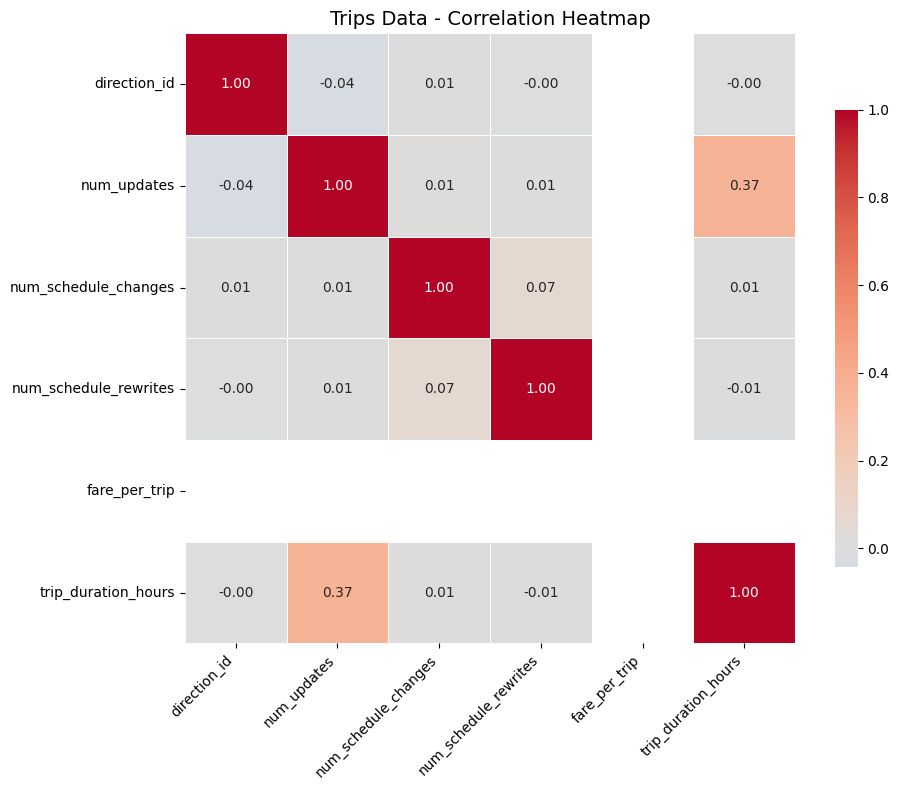


🔗 Correlation Heatmap for: Stops Data (Pearson method)
⚠️ Not enough numerical columns to compute correlation.


In [26]:
#Correlation

import seaborn as sns
import matplotlib.pyplot as plt

def correlation_summary(df, df_name='DataFrame', figsize=(10, 8), method='pearson'):
    print(f"\n{'='*80}")
    print(f"🔗 Correlation Heatmap for: {df_name} ({method.title()} method)")
    
    num_cols = df.select_dtypes(include='number')
    if num_cols.shape[1] < 2:
        print("⚠️ Not enough numerical columns to compute correlation.")
        return

    corr_matrix = num_cols.corr(method=method)

    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75}
    )
    plt.title(f"{df_name} - Correlation Heatmap", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
# Show correlation heatmaps for all dataframes
correlation_summary(all_trips, 'Trips Data')
correlation_summary(all_stop_times, 'Stops Data')

In [70]:
#all_trips and all_stop_times head
from IPython.display import display

# Show both DataFrames
display(all_trips.head())
display(all_stop_times.head())

,trip_uid,trip_id,route_id,direction_id,start_time,vehicle_id,last_observed,marked_past,num_updates,num_schedule_changes,num_schedule_rewrites,date,fare_per_trip,trip_duration_hours,hour,weekday,is_weekend,day_type,pickup_day,pickup_hour
0,1704167460_N..S,023100_N..S,N,1,2024-01-01 22:51:00,1N 0350+ DIT/STL,2024-01-02 04:59:57,2024-01-02 04:59:57,815,0,0,2024-01-01,2.9,1.221111,22,0,False,Weekday,Monday,22
1,1704110910_L..N,072850_L..N,L,0,2024-01-01 07:08:30,0L 1208+105/8AV,2024-01-01 12:38:52,2024-01-01 12:39:02,480,0,0,2024-01-01,2.9,0.533611,7,0,False,Weekday,Monday,7
2,1704106800_C..N,066000_C..N,C,0,2024-01-01 06:00:00,1C 1100 EUC/168,2024-01-01 12:06:35,2024-01-01 12:06:45,1400,0,0,2024-01-01,2.9,1.098611,6,0,False,Weekday,Monday,6
3,1704115440_L..S,080400_L..S,L,1,2024-01-01 08:24:00,0L 1324 8AV/RPY,2024-01-01 13:57:52,2024-01-01 13:58:02,512,0,0,2024-01-01,2.9,0.557500,8,0,False,Weekday,Monday,8
4,1704155130_1..S03R,002550_1..S03R,1,1,2024-01-01 19:25:30,01 0025+ 242/SFT,2024-01-02 01:34:22,2024-01-02 01:34:26,601,0,0,2024-01-01,2.9,1.131111,19,0,False,Weekday,Monday,19


,trip_uid,stop_id,track,arrival_time,departure_time,last_observed,marked_past,date,Borough,stop_duration_seconds,day_type,hour
0,1704085620_3..N42R,127N,2,2024-01-01 05:07:00,2024-01-01 05:07:00,2024-01-01 04:51:04,2024-01-01 04:51:08,2024-01-01,Manhattan,32.413434,Weekday,5
1,1704085620_3..N42R,123N,3,2024-01-01 04:54:34,2024-01-01 04:54:34,2024-01-01 04:56:19,2024-01-01 04:57:34,2024-01-01,Manhattan,32.413434,Weekday,4
2,1704085620_3..N42R,120N,3,2024-01-01 04:57:04,2024-01-01 04:57:04,2024-01-01 04:56:19,2024-01-01 04:57:34,2024-01-01,Manhattan,32.413434,Weekday,4
3,1704085620_3..N42R,227N,3,2024-01-01 05:01:04,2024-01-01 05:01:04,2024-01-01 04:56:19,2024-01-01 04:57:34,2024-01-01,Manhattan,32.413434,Weekday,5
4,1704085620_3..N42R,226N,3,2024-01-01 05:02:04,2024-01-01 05:02:04,2024-01-01 04:56:19,2024-01-01 04:57:34,2024-01-01,Manhattan,32.413434,Weekday,5


In [1]:
#read all_trips & all_stop_times from parquet files
import pandas as pd
all_trips = pd.read_parquet('C:/Users/ahmed.mabdullah/Desktop/GUC/Capstone Project/Subway_data/2024 Subway/subway_data_2024/processed_data/Final/final_trips.parquet')
all_stop_times = pd.read_parquet('C:/Users/ahmed.mabdullah/Desktop/GUC/Capstone Project/Subway_data/2024 Subway/subway_data_2024/processed_data/Final/final_stops.parquet')

In [13]:
#sort by trip_duration_hours by descending order
all_trips_sorted = all_trips.sort_values(by='trip_duration_hours', ascending=False)
all_trips_sorted.head(60)

,trip_uid,trip_id,route_id,direction_id,start_time,vehicle_id,last_observed,marked_past,num_updates,num_schedule_changes,num_schedule_rewrites,date,fare_per_trip,trip_duration_hours,hour,weekday,is_weekend,day_type,pickup_day,pickup_hour
223119,1715126220_A..S,143700_A..S,A,1,2024-05-07 19:57:00,1A 2357 207/FAR,2024-05-08 02:10:46,2024-05-08 02:10:53,2358,1,0,2024-05-07,2.9,25.975278,19,1,False,Weekday,Tuesday,19
326687,1720569540_A..S74R,143900_A..S74R,A,1,2024-07-09 19:59:00,1A 2359 207/FAR,2024-07-10 02:02:18,2024-07-10 02:02:26,4268,1,1,2024-07-09,2.9,25.881111,19,1,False,Weekday,Tuesday,19
481698,1728518220_N..N20R,143700_N..N20R,N,0,2024-10-09 19:57:00,1N 2357 STL/DIT,2024-10-10 01:56:15,2024-10-10 01:56:27,1775,0,0,2024-10-09,2.9,25.858333,19,2,False,Weekday,Wednesday,19
91767,1708559850_D..S05R,143750_D..S05R,D,1,2024-02-21 18:57:30,1D 2357+ BPK/STL,2024-02-22 01:48:30,2024-02-22 01:48:38,1406,0,0,2024-02-21,2.9,25.551111,18,2,False,Weekday,Wednesday,18
331155,1720742010_D..S,143350_D..S,D,1,2024-07-11 19:53:30,1D 2353+ BPK/STL,2024-07-12 00:59:55,2024-07-12 01:59:57,3028,3,0,2024-07-11,2.9,25.389444,19,3,False,Weekday,Thursday,19
45407,1706217600_1..S12R,128000_1..S12R,1,1,2024-01-25 16:20:00,01 2120 137/SFT,2024-01-25 08:32:11,2024-01-25 08:32:24,358,0,0,2024-01-25,2.9,12.783056,16,3,False,Weekday,Thursday,16
292301,1718755830_N..S20R,001050_N..S20R,N,1,2024-06-18 20:10:30,1N 0010+ DIT/STL,2024-06-19 02:39:56,2024-06-19 02:40:03,3376,0,0,2024-06-18,2.9,11.180833,20,1,False,Weekday,Tuesday,20
662,1704100440_J..N,055400_J..N,J,0,2024-01-01 04:14:00,1J 1914 BRD/P-A,2024-01-01 20:04:11,2024-01-01 20:04:18,1830,0,0,2024-01-01,2.9,10.843889,4,0,False,Weekday,Monday,4
222311,1715070090_R..S71R,050150_R..S71R,R,1,2024-05-07 04:21:30,1R 0821+ CTL/95S,2024-05-07 10:02:46,2024-05-07 10:02:55,1671,0,0,2024-05-07,2.9,10.399722,4,1,False,Weekday,Tuesday,4
291226,1718612490_Q..S16R,050150_Q..S16R,Q,1,2024-06-17 04:21:30,1Q 0821+ 962/STL,2024-06-17 09:39:37,2024-06-17 09:39:41,1779,0,0,2024-06-17,2.9,9.931111,4,0,False,Weekday,Monday,4


In [15]:
#show me all_stop_times when trip_uid = "1715126220_A..S"
specific_trip_uid = "1715070090_R..S71R"
specific_trip_data = all_stop_times[all_stop_times['trip_uid'] == specific_trip_uid]
specific_trip_data.head(60)

,trip_uid,stop_id,track,arrival_time,departure_time,last_observed,marked_past,date,Borough,stop_duration_seconds,day_type,hour,stop_id_clean
15128670,1715070090_R..S71R,G08S,D1,2024-05-07 08:22:01,2024-05-07 08:22:01,2024-05-07 08:22:26,2024-05-07 08:22:34,2024-05-07,Queens,32.413434,Weekday,8,G08
15128671,1715070090_R..S71R,G09S,D1,2024-05-07 08:23:46,2024-05-07 08:23:46,2024-05-07 08:24:14,2024-05-07 08:24:16,2024-05-07,Queens,32.413434,Weekday,8,G09
15128672,1715070090_R..S71R,G10S,D1,2024-05-07 08:25:21,2024-05-07 08:25:21,2024-05-07 08:25:46,2024-05-07 08:25:54,2024-05-07,Queens,32.413434,Weekday,8,G10
15128673,1715070090_R..S71R,G11S,D1,2024-05-07 08:26:56,2024-05-07 08:26:56,2024-05-07 08:27:24,2024-05-07 08:27:27,2024-05-07,Queens,32.413434,Weekday,8,G11
15128674,1715070090_R..S71R,G12S,D1,2024-05-07 08:28:39,2024-05-07 08:28:39,2024-05-07 08:29:07,2024-05-07 08:29:14,2024-05-07,Queens,32.413434,Weekday,8,G12
15128675,1715070090_R..S71R,G13S,D1,2024-05-07 08:30:26,2024-05-07 08:30:26,2024-05-07 08:30:54,2024-05-07 08:30:57,2024-05-07,Queens,32.413434,Weekday,8,G13
15128676,1715070090_R..S71R,G14S,D1,2024-05-07 08:32:19,2024-05-07 08:32:19,2024-05-07 08:32:47,2024-05-07 08:32:54,2024-05-07,Queens,32.413434,Weekday,8,G14
15128677,1715070090_R..S71R,G15S,D1,2024-05-07 08:33:54,2024-05-07 08:33:54,2024-05-07 08:34:17,2024-05-07 08:34:24,2024-05-07,Queens,32.413434,Weekday,8,G15
15128678,1715070090_R..S71R,G16S,D1,2024-05-07 08:35:31,2024-05-07 08:35:31,2024-05-07 08:35:57,2024-05-07 08:36:04,2024-05-07,Queens,32.413434,Weekday,8,G16
15128679,1715070090_R..S71R,G18S,D1,2024-05-07 08:37:09,2024-05-07 08:37:09,2024-05-07 08:37:37,2024-05-07 08:37:44,2024-05-07,Queens,32.413434,Weekday,8,G18


# Analysis

🟦 Trips Count per Borough

    Chart Type: Bar Chart

    Data: all_stop_times

    Goal: Count number of unique trips per borough

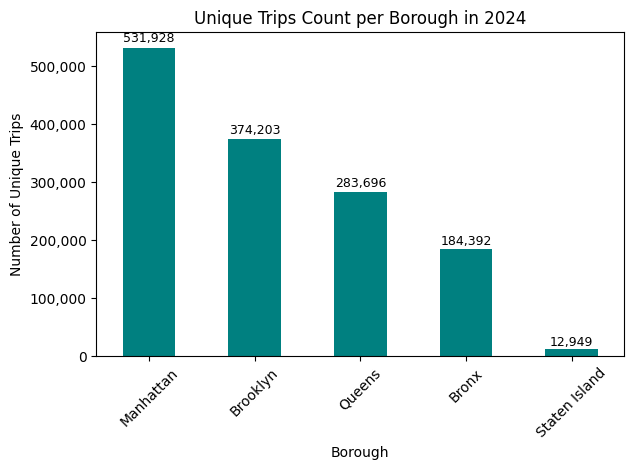

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Ensure 'date' is datetime type (if needed)
all_stop_times['date'] = pd.to_datetime(all_stop_times['date'])

# Count unique trips per borough
trips_per_borough = all_stop_times.groupby('Borough')['trip_uid'].nunique().sort_values(ascending=False)

# Plot
ax = trips_per_borough.plot(kind='bar', color='teal')
plt.title('Unique Trips Count per Borough in 2024')
plt.ylabel('Number of Unique Trips')
plt.xlabel('Borough')
plt.xticks(rotation=45)
#plt.grid(axis='y')
plt.tight_layout()

# Format y-axis with commas
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Add numbers above bars
for i, value in enumerate(trips_per_borough):
    ax.text(i, value + value * 0.01, f'{value:,}', ha='center', va='bottom', fontsize=9)

plt.show()

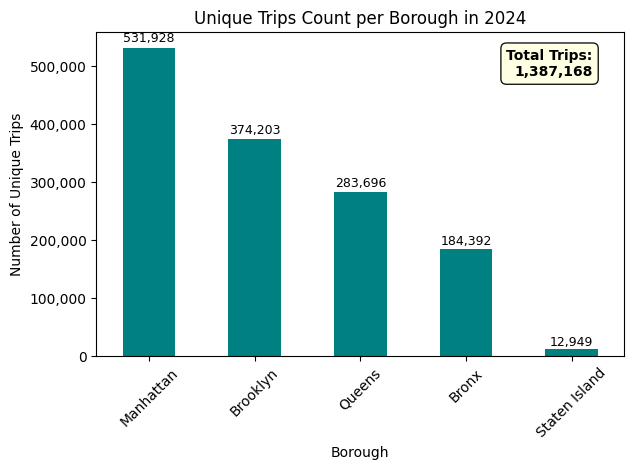

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Ensure 'date' is datetime type (if needed)
all_stop_times['date'] = pd.to_datetime(all_stop_times['date'])

# Count unique trips per borough
trips_per_borough = all_stop_times.groupby('Borough')['trip_uid'].nunique().sort_values(ascending=False)

# Calculate total unique trips
total_trips = trips_per_borough.sum()

# Plot
ax = trips_per_borough.plot(kind='bar', color='teal')
plt.title('Unique Trips Count per Borough in 2024')
plt.ylabel('Number of Unique Trips')
plt.xlabel('Borough')
plt.xticks(rotation=45)
plt.tight_layout()

# Format y-axis with commas
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Add numbers above bars
for i, value in enumerate(trips_per_borough):
    ax.text(i, value + value * 0.01, f'{value:,}', ha='center', va='bottom', fontsize=9)

# Add total in top-right corner as a rectangle
plt.text(
    len(trips_per_borough) - 0.8,                # x position (rightmost bar)
    ax.get_ylim()[1] * 0.95,                     # y position (95% of the y-limit)
    f'Total Trips:\n{total_trips:,}',            # text string
    fontsize=10,
    fontweight='bold',
    ha='right',
    va='top',
    color='black',
    bbox=dict(boxstyle='round,pad=0.4', fc='lightyellow', ec='black', alpha=0.9)
)

plt.show()

🟦 Stops Count per Borough

    Chart Type: Bar Chart

    Data: all_stop_times

    Goal: Count number of unique stops per borough

In [4]:
print(all_stop_times['stop_id'].unique().tolist())

['127N', '123N', '120N', '227N', '226N', '225N', '224N', '302N', '301N', '247N', '246N', '245N', '244N', '243N', '242N', '241N', '239N', '238N', '237N', '236N', '235N', '234N', '233N', '232N', '231N', '230N', '229N', '228N', '137N', '136N', '135N', '134N', '133N', '132N', '131N', '130N', '129N', '128N', '126N', '125N', '124N', '122N', '121N', '222N', '221N', '220N', '219N', '218N', '217N', '216N', '215N', '214N', '213N', '212N', '211N', '210N', '209N', '208N', '207N', '206N', '205N', '204N', '201N', '640N', '639N', '638N', '637N', '636N', '635N', '634N', '633N', '632N', '631N', '630N', '629N', '628N', '627N', '626N', '625N', '624N', '623N', '622N', '621N', '619N', '618N', '617N', '616N', '615N', '614N', '613N', '612N', '611N', '610N', '609N', '608N', '607N', '606N', '604N', '603N', '602N', '601N', '401S', '402S', '405S', '406S', '407S', '408S', '409S', '410S', '411S', '412S', '413S', '414S', '415S', '416S', '621S', '622S', '623S', '624S', '625S', '626S', '627S', '628S', '629S', '630S',

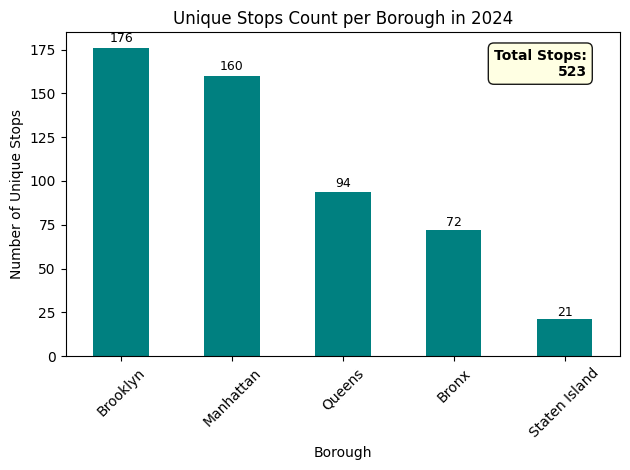

In [18]:
# Remove trailing 'N' or 'S' only, not internal letters
all_stop_times['stop_id_clean'] = all_stop_times['stop_id'].str.replace(r'[NS]$', '', regex=True)

# Count unique directionless stops per borough
stops_per_borough = all_stop_times.groupby('Borough')['stop_id_clean'].nunique().sort_values(ascending=False)

# Calculate total unique stops
total_stops = stops_per_borough.sum()

# Plot
ax = stops_per_borough.plot(kind='bar', color='teal')
plt.title('Unique Stops Count per Borough in 2024')
plt.ylabel('Number of Unique Stops')
plt.xlabel('Borough')
plt.xticks(rotation=45)
plt.tight_layout()

# Format y-axis with commas
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Add numbers above bars
for i, value in enumerate(stops_per_borough):
    ax.text(i, value + value * 0.01, f'{value:,}', ha='center', va='bottom', fontsize=9)

# Add total stops in top-right corner as a rectangle
plt.text(
    len(stops_per_borough) - 0.8,
    ax.get_ylim()[1] * 0.95,
    f'Total Stops:\n{total_stops:,}',
    fontsize=10,
    fontweight='bold',
    ha='right',
    va='top',
    color='black',
    bbox=dict(boxstyle='round,pad=0.4', fc='lightyellow', ec='black', alpha=0.9)
)

plt.show()

In [6]:
all_stop_times.head()

,trip_uid,stop_id,track,arrival_time,departure_time,last_observed,marked_past,date,Borough,stop_duration_seconds,day_type,hour,stop_id_clean
0,1704085620_3..N42R,127N,2,2024-01-01 05:07:00,2024-01-01 05:07:00,2024-01-01 04:51:04,2024-01-01 04:51:08,2024-01-01,Manhattan,32.413434,Weekday,5,127
1,1704085620_3..N42R,123N,3,2024-01-01 04:54:34,2024-01-01 04:54:34,2024-01-01 04:56:19,2024-01-01 04:57:34,2024-01-01,Manhattan,32.413434,Weekday,4,123
2,1704085620_3..N42R,120N,3,2024-01-01 04:57:04,2024-01-01 04:57:04,2024-01-01 04:56:19,2024-01-01 04:57:34,2024-01-01,Manhattan,32.413434,Weekday,4,120
3,1704085620_3..N42R,227N,3,2024-01-01 05:01:04,2024-01-01 05:01:04,2024-01-01 04:56:19,2024-01-01 04:57:34,2024-01-01,Manhattan,32.413434,Weekday,5,227
4,1704085620_3..N42R,226N,3,2024-01-01 05:02:04,2024-01-01 05:02:04,2024-01-01 04:56:19,2024-01-01 04:57:34,2024-01-01,Manhattan,32.413434,Weekday,5,226


🟦  Distribution of Trip Duration (all_stop_times)

    Chart Type: Histogram

    Insight: Typical trip lengths in hours

    Conclusion: Most trips last around 5–6 hours. Long tails may indicate delays or data issues.

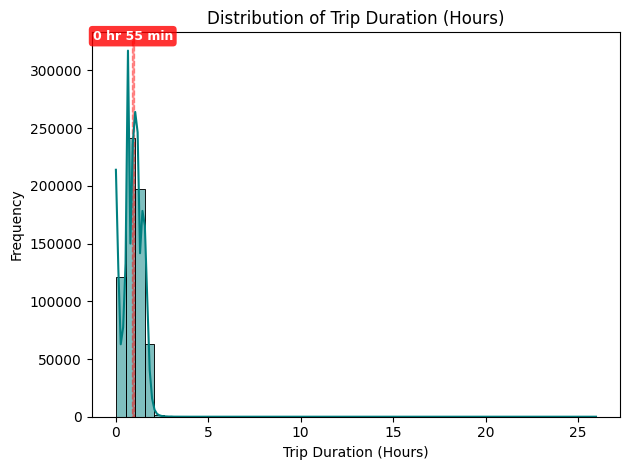

In [19]:
import seaborn as sns
# Calculate average trip duration in hours
avg_duration = all_trips['trip_duration_hours'].mean()

# Convert to hours and minutes
avg_hours = int(avg_duration)
avg_minutes = int(round((avg_duration - avg_hours) * 60))
avg_label = f'{avg_hours} hr {avg_minutes} min'

# Plot histogram
sns.histplot(all_trips['trip_duration_hours'], bins=50, kde=True, color='teal')

# Add a small vertical rectangle around the average (±0.05 hrs)
plt.axvspan(avg_duration - 0.05, avg_duration + 0.05, color='red', alpha=0.4,linestyle='--')

# Add label inside the rectangle
plt.text(
    avg_duration,                 # x: center of the rectangle
    plt.ylim()[1] * 0.99,         # y: 85% of y-axis height
    avg_label,
    color='white',
    ha='center',
    va='center',
    fontsize=9,
    fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.3', fc='red', ec='none', alpha=0.8)
)

# Titles and labels
plt.title('Distribution of Trip Duration (Hours)')
plt.xlabel('Trip Duration (Hours)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

🟦  Top 10 Most Frequent Routes

    Chart Type: Bar Chart

    Insight: Most heavily used subway routes
    
    Conclusion: Could be prioritized for maintenance, optimization

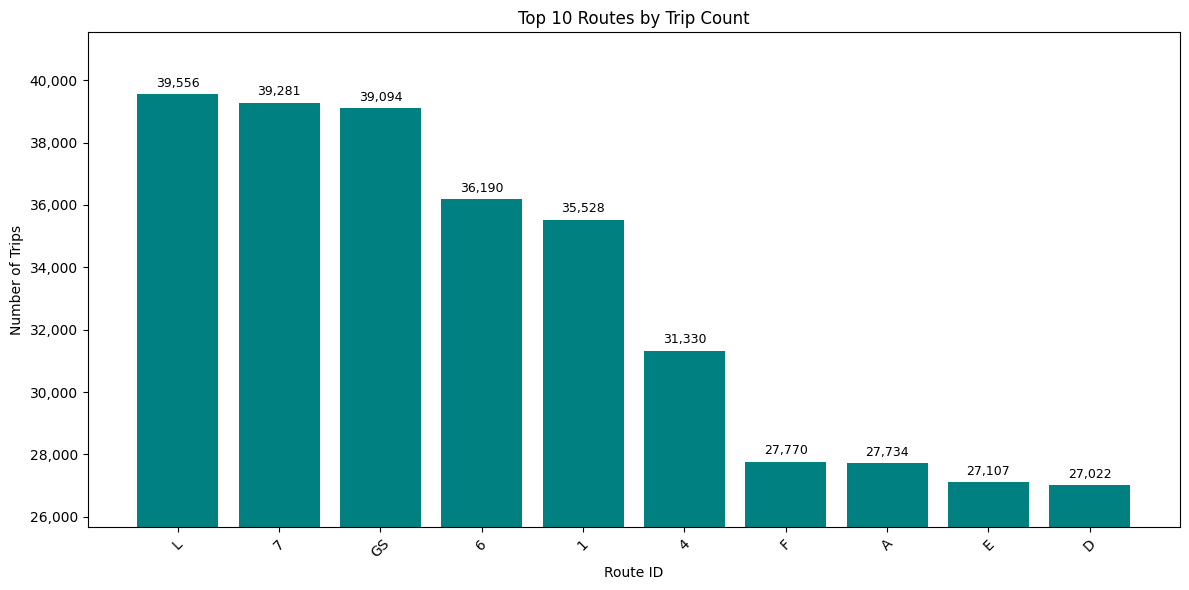

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

top_routes = all_trips['route_id'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(top_routes.index.astype(str), top_routes.values, color='teal')

ax.set_title('Top 10 Routes by Trip Count')
ax.set_xlabel('Route ID')
ax.set_ylabel('Number of Trips')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Tighter y-axis limits
y_min = top_routes.values.min() * 0.95
y_max = top_routes.values.max() * 1.05
ax.set_ylim(y_min, y_max)

plt.xticks(rotation=45)

# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height):,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


🟦  Daily Number of Trips

    Chart Type: Time Series Line Plot

    Insight: Subway usage pattern over time
    
    Conclusion: Detects rush hours, weekends, special events

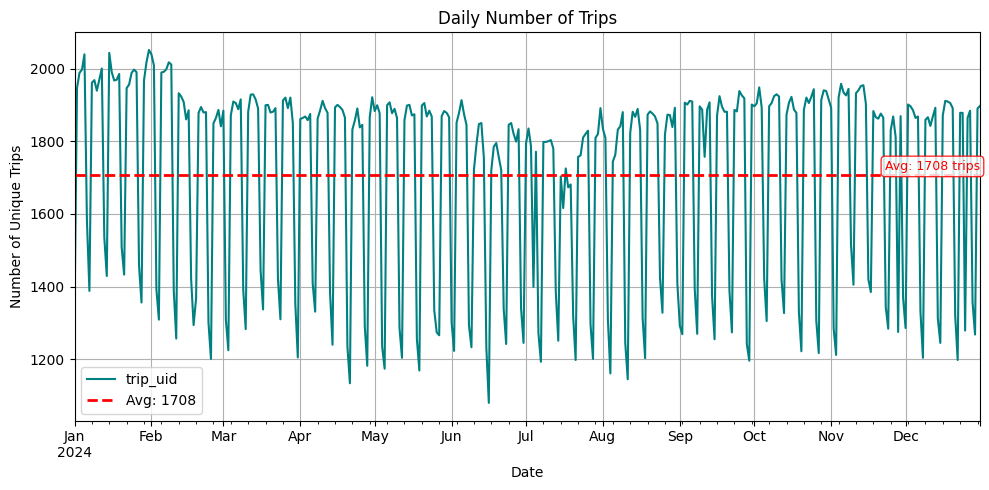

In [21]:
# Group by date and count unique trips
daily_trips = all_stop_times.groupby('date')['trip_uid'].nunique()

# Calculate average
avg_daily_trips = daily_trips.mean()

# Plot the daily trips line
ax = daily_trips.plot(figsize=(10, 5), title='Daily Number of Trips', color='teal')
plt.ylabel('Number of Unique Trips')
plt.xlabel('Date')
plt.grid(True)

# Add horizontal average line
plt.axhline(avg_daily_trips, color='red', linestyle='--', linewidth=2, label=f'Avg: {avg_daily_trips:.0f}')

# Add label directly on the chart (optional)
plt.text(
    daily_trips.index[-1],       # far right of the x-axis
    avg_daily_trips + 5,         # slightly above the line
    f'Avg: {avg_daily_trips:.0f} trips',
    color='red',
    fontsize=9,
    ha='right',
    va='bottom',
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='red', alpha=0.8)
)

# Show legend
plt.legend()

# Layout
plt.tight_layout()
plt.show()

🟦  Average Daily Trips per Borough

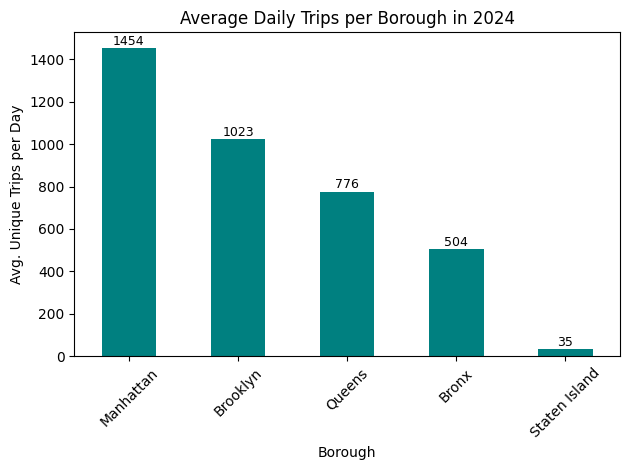

In [22]:
import matplotlib.pyplot as plt

# Step 1: Count unique trips per borough per day
daily_trips = all_stop_times.groupby(['Borough', 'date'])['trip_uid'].nunique().reset_index(name='daily_trip_count')

# Step 2: Calculate average trips per day for each borough
avg_daily_trips = daily_trips.groupby('Borough')['daily_trip_count'].mean().sort_values(ascending=False)

# Step 3: Plot
ax = avg_daily_trips.plot(kind='bar', color='teal')
plt.title('Average Daily Trips per Borough in 2024')
plt.ylabel('Avg. Unique Trips per Day')
plt.xlabel('Borough')
plt.xticks(rotation=45)
plt.tight_layout()

# Add numbers on top of each bar
for i, v in enumerate(avg_daily_trips):
    plt.text(i, v + 1, f'{v:.0f}', ha='center', va='bottom', fontsize=9)

plt.show()


🟦  Top 10 Stops by Frequency

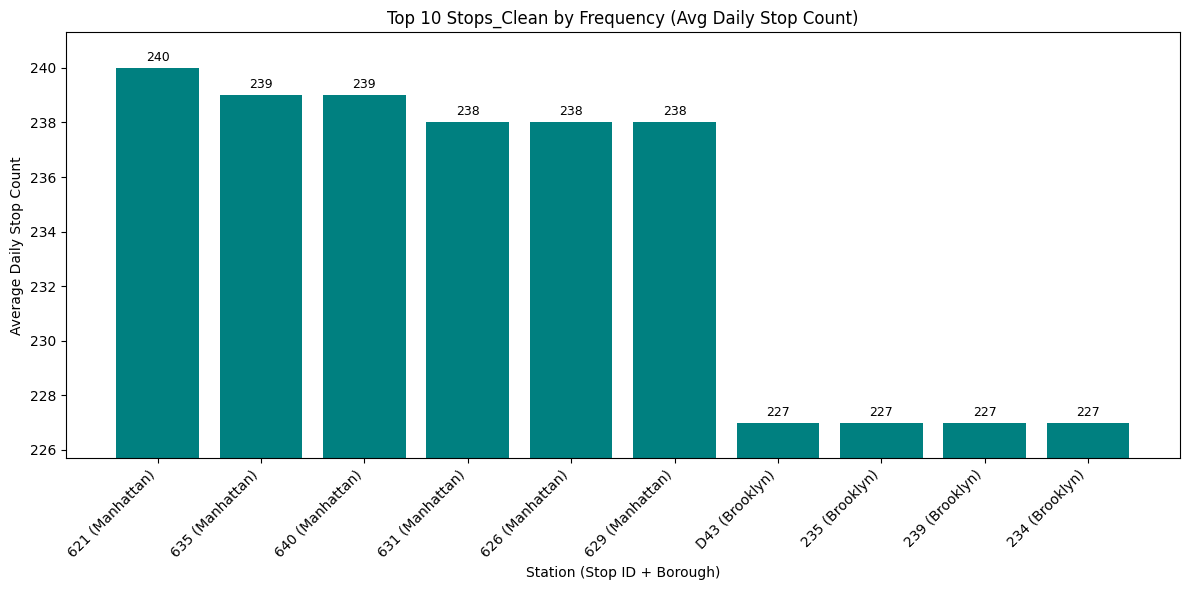

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd

# === 1. Ensure 'date' column is in datetime format
all_stop_times['date'] = pd.to_datetime(all_stop_times['date'], errors='coerce')

# === 2. Drop rows with missing stop_id_clean or date
filtered = all_stop_times[['stop_id_clean', 'date']].dropna()

# === 3. Group by stop and day, count appearances
daily_counts = (
    filtered
    .groupby(['stop_id_clean', filtered['date'].dt.date])
    .size()
    .reset_index(name='count')
)

# === 4. Compute average daily count per stop_id_clean
avg_daily_stops = (
    daily_counts
    .groupby('stop_id_clean')['count']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# === 5. Load lookup table and clean column names
lookup_path = r"C:\Users\ahmed.mabdullah\Desktop\GUC\Capstone Project\Subway_data\2024 Subway\Lookup_StationsID_Borough.csv"
lookup_df = pd.read_csv(
    lookup_path,
    usecols=['stop_id', 'Borough'],
    encoding='ISO-8859-1'
)
lookup_df.columns = lookup_df.columns.str.strip().str.lower()  # now: 'stop_id', 'borough'

# === 6. Clean stop_id in lookup to match stop_id_clean
lookup_df['stop_id_clean'] = lookup_df['stop_id'].str.replace(r'[NS]$', '', regex=True)

# === 7. Merge top 10 with boroughs
top_10 = avg_daily_stops.merge(lookup_df[['stop_id_clean', 'borough']], on='stop_id_clean', how='left').drop_duplicates()

# === 8. Create x-axis labels
top_10['label'] = top_10['stop_id_clean'] + ' (' + top_10['borough'] + ')'

# === Round counts before plotting to ensure same rounded values have same height
top_10['count_rounded'] = top_10['count'].round(0)

# === 9. Plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(top_10['label'], top_10['count_rounded'], color='teal')

ax.set_title('Top 10 Stops_Clean by Frequency (Avg Daily Stop Count)')
ax.set_xlabel('Station (Stop ID + Borough)')
ax.set_ylabel('Average Daily Stop Count')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.xticks(rotation=45, ha='right')

# === Adjust y-axis scale based on rounded counts
min_count = top_10['count_rounded'].min()
max_count = top_10['count_rounded'].max()
margin = (max_count - min_count) * 0.1
lower_limit = max(min_count - margin, 0)
ax.set_ylim(lower_limit, max_count + margin)

# === 10. Add annotations with rounded values
for bar, height in zip(bars, top_10['count_rounded']):
    ax.annotate(f'{int(height):,}', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


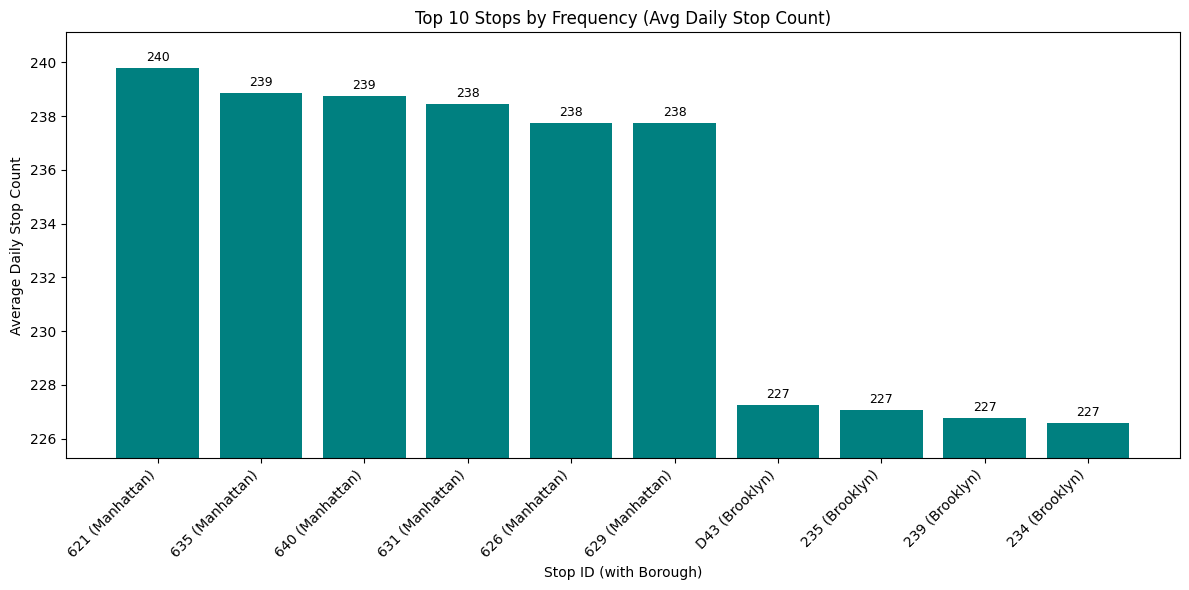

In [24]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(top_10['label'], top_10['count'], color='teal')

ax.set_title('Top 10 Stops by Frequency (Avg Daily Stop Count)')
ax.set_xlabel('Stop ID (with Borough)')
ax.set_ylabel('Average Daily Stop Count')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.xticks(rotation=45, ha='right')

# Add numbers above bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

# Adjust y-axis limits to zoom in a bit
min_count = top_10['count'].min()
max_count = top_10['count'].max()
margin = (max_count - min_count) * 0.1  # 10% margin

ax.set_ylim(min_count - margin, max_count + margin)

plt.tight_layout()
plt.show()


🟦  Average Daily Trips by Borough: Weekdays vs Weekends

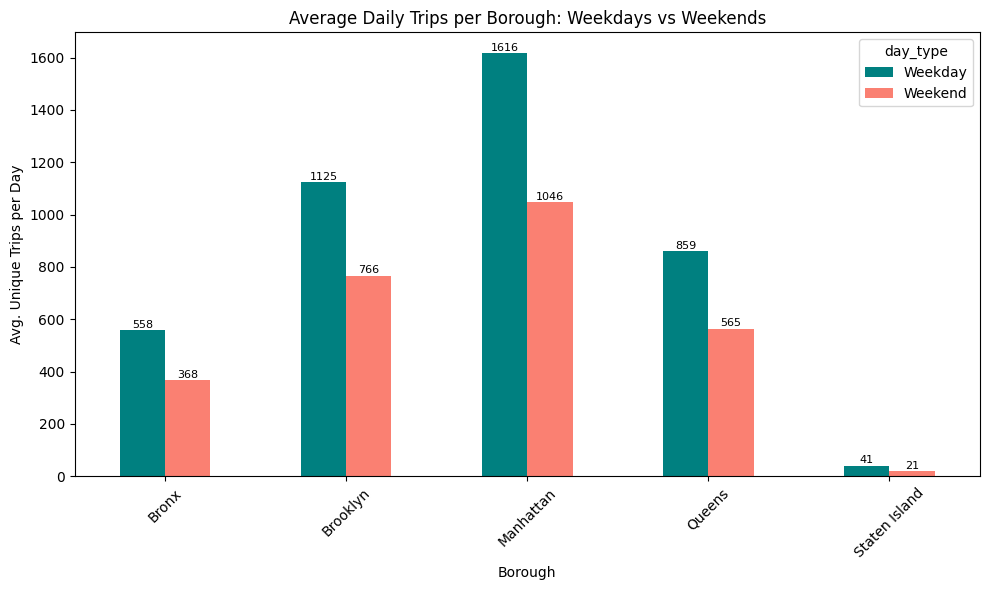

In [34]:
import matplotlib.pyplot as plt

# Ensure datetime format
all_stop_times['date'] = pd.to_datetime(all_stop_times['date'])

# Add weekday/weekend column
all_stop_times['day_type'] = all_stop_times['date'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Group by Borough, date and day_type → count unique trips
daily_counts = all_stop_times.groupby(['Borough', 'date', 'day_type'])['trip_uid'].nunique().reset_index(name='daily_trip_count')

# Now group again to get average per borough for each day_type
avg_counts = daily_counts.groupby(['Borough', 'day_type'])['daily_trip_count'].mean().reset_index()

# Pivot for plotting
pivot_data = avg_counts.pivot(index='Borough', columns='day_type', values='daily_trip_count').fillna(0)

# Plot grouped bar chart
ax = pivot_data.plot(kind='bar', figsize=(10,6), color=['teal', 'salmon'])
plt.title('Average Daily Trips per Borough: Weekdays vs Weekends')
plt.ylabel('Avg. Unique Trips per Day')
plt.xlabel('Borough')
plt.xticks(rotation=45)
#plt.grid(axis='y')
plt.tight_layout()

# Add number on top of each bar
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 1,
                f'{height:.0f}',
                ha='center',
                va='bottom',
                fontsize=8
            )

plt.show()


🟦 Top 10 stops with the highest average stop duration

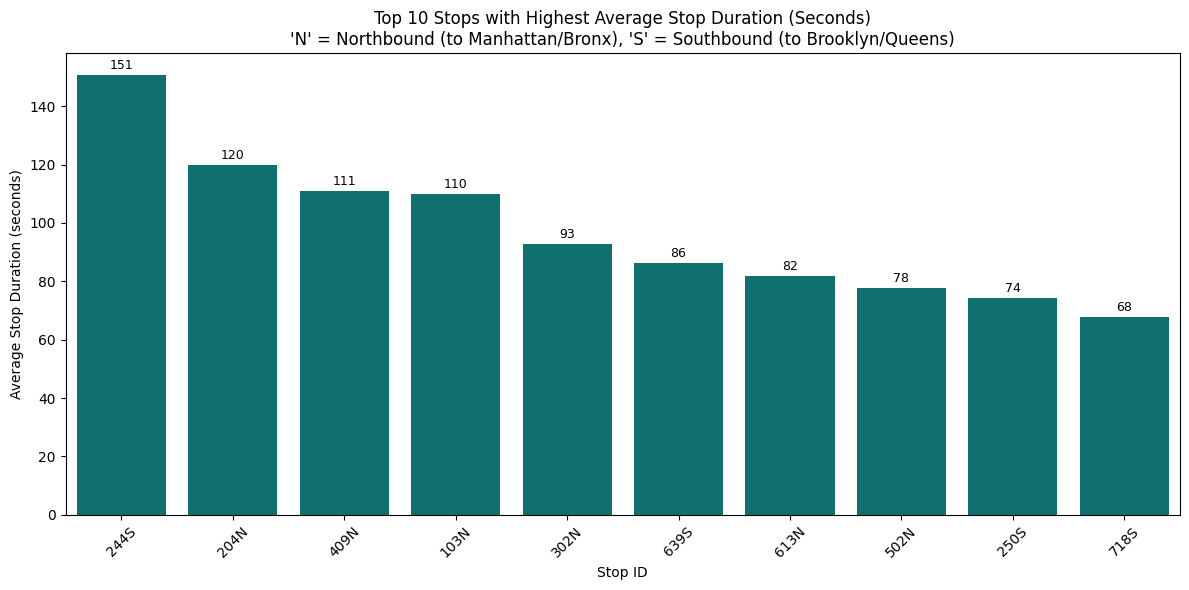

In [25]:
# Calculate top 10 average stop durations
top_avg_stop_durations = (
    all_stop_times
    .groupby('stop_id')['stop_duration_seconds']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_avg_stop_durations,
    x='stop_id',
    y='stop_duration_seconds',
    color='teal'  # Single color
)

# Add numbers on top of bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{height:.0f}',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.xlabel('Stop ID')
plt.ylabel('Average Stop Duration (seconds)')
#plt.title('Top 10 Stops with Highest Average Stop Duration (Seconds)')
plt.title('Top 10 Stops with Highest Average Stop Duration (Seconds)\n'
          "'N' = Northbound (to Manhattan/Bronx), 'S' = Southbound (to Brooklyn/Queens)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


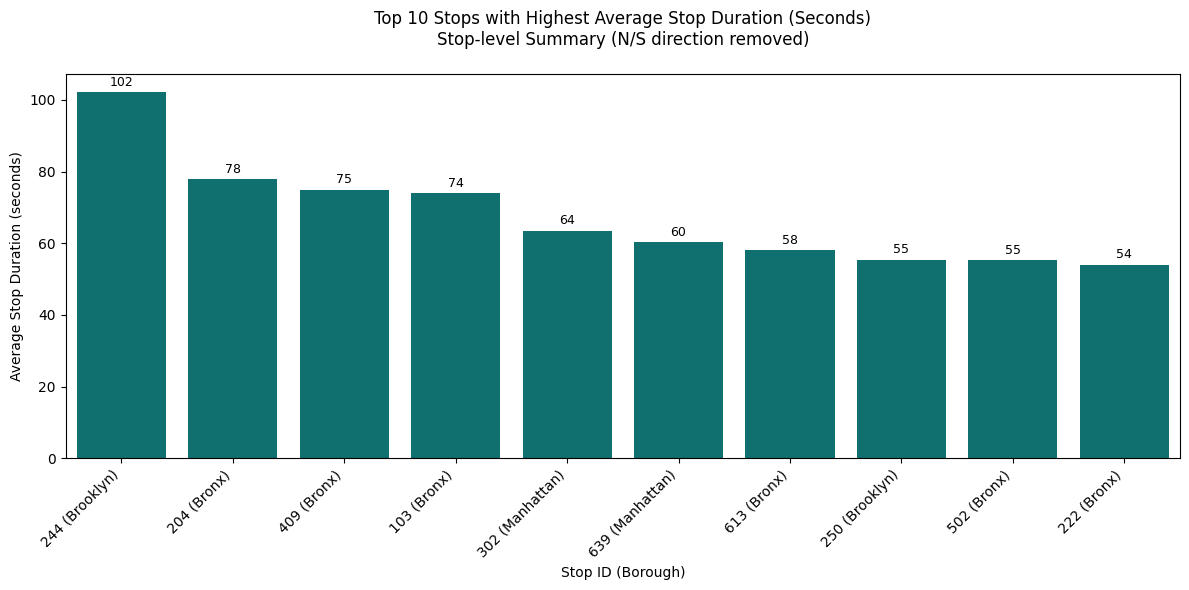

In [26]:
import seaborn as sns
# === 1. Clean stop_id to remove N/S direction (if not already done)
all_stop_times['stop_id_clean'] = all_stop_times['stop_id'].str.replace(r'[NS]$', '', regex=True)

# === 2. Compute average stop duration for each stop_id_clean
top_avg_stop_durations = (
    all_stop_times
    .groupby('stop_id_clean')['stop_duration_seconds']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# === 3. Load lookup and clean column names
lookup_path = r"C:\Users\ahmed.mabdullah\Desktop\GUC\Capstone Project\Subway_data\2024 Subway\Lookup_StationsID_Borough.csv"
lookup_df = pd.read_csv(
    lookup_path,
    usecols=['stop_id', 'Borough'],
    encoding='ISO-8859-1'
)
lookup_df.columns = lookup_df.columns.str.strip().str.lower()

# === 4. Create stop_id_clean in lookup to match cleaned IDs
lookup_df['stop_id_clean'] = lookup_df['stop_id'].str.replace(r'[NS]$', '', regex=True)

# === 5. Merge top 10 with Borough info
top_avg_stop_durations = top_avg_stop_durations.merge(
    lookup_df[['stop_id_clean', 'borough']],
    on='stop_id_clean',
    how='left'
).drop_duplicates()

# === 6. Create label: stop_id_clean (Borough)
top_avg_stop_durations['label'] = top_avg_stop_durations['stop_id_clean'] + ' (' + top_avg_stop_durations['borough'] + ')'

# === 7. Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_avg_stop_durations,
    x='label',
    y='stop_duration_seconds',
    color='teal'
)

# Add numbers on top of bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{height:.0f}',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.xlabel('Stop ID (Borough)')
plt.ylabel('Average Stop Duration (seconds)')
plt.title('Top 10 Stops with Highest Average Stop Duration (Seconds)\n'
          "Stop-level Summary (N/S direction removed)\n")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

🟦 Hourly Distribution of Trips Over the Day

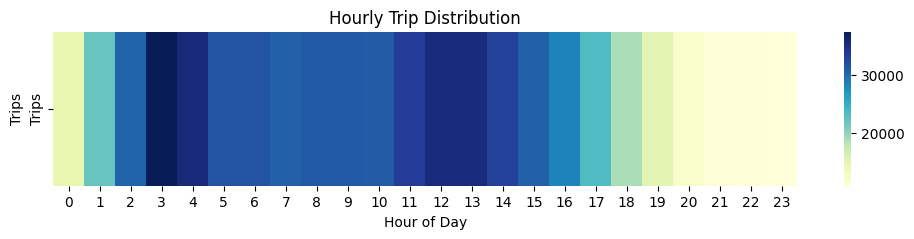

In [ ]:
# Extract hour and weekday
all_trips['hour'] = all_trips['start_time'].dt.hour
hourly_counts = all_trips['hour'].value_counts().sort_index()

# Plot heatmap as a single row (hour vs count)
plt.figure(figsize=(12, 2))
sns.heatmap(hourly_counts.values.reshape(1, -1), cmap="YlGnBu", cbar=True,
            xticklabels=hourly_counts.index, yticklabels=["Trips"])
plt.title("Hourly Trip Distribution")
plt.xlabel("Hour of Day")
plt.ylabel("Trips")
plt.show()

🟦 Stop Duration in Each Hour Over the Day

🕐 The New York City Subway operates 24 hours a day, 7 days a week, all year round, without any official closures.

Source: MTA Official Website

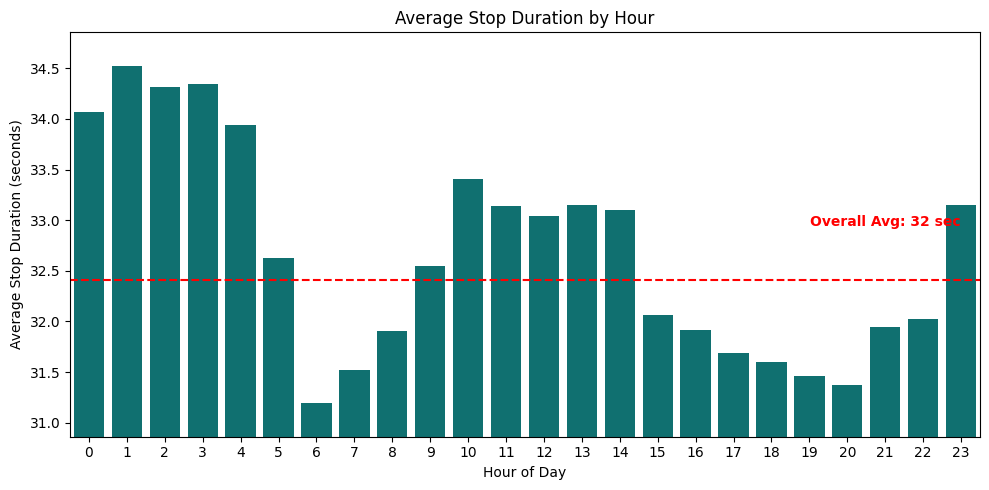

In [32]:
from matplotlib import patches

# Group by hour
hourly_stop_duration = all_stop_times.groupby('hour')['stop_duration_seconds'].mean()

# Calculate overall average
total_avg = all_stop_times['stop_duration_seconds'].mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=hourly_stop_duration.index, y=hourly_stop_duration.values, ax=ax, color='teal')

# Add a horizontal line for overall average
ax.axhline(total_avg, color='red', linestyle='--', linewidth=1.5)

# Add label for the average line
ax.text(
    x=23,  # near the right edge of x-axis (hour 23)
    y=total_avg + 0.5,  # slightly above the line
    s=f'Overall Avg: {int(total_avg)} sec',
    color='red',
    fontsize=10,
    fontweight='bold',
    ha='right',
    va='bottom'
)

# Zoom y-axis around the data for better visual
min_val = hourly_stop_duration.min()
max_val = hourly_stop_duration.max()
margin = (max_val - min_val) * 0.1  # 10% margin
ax.set_ylim(min_val - margin, max_val + margin)

ax.set_title("Average Stop Duration by Hour")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average Stop Duration (seconds)")
ax.set_xticks(range(0, 24))
plt.tight_layout()
plt.show()


🟦 Heatmap: Hourly Trips vs Weekday/Weekend

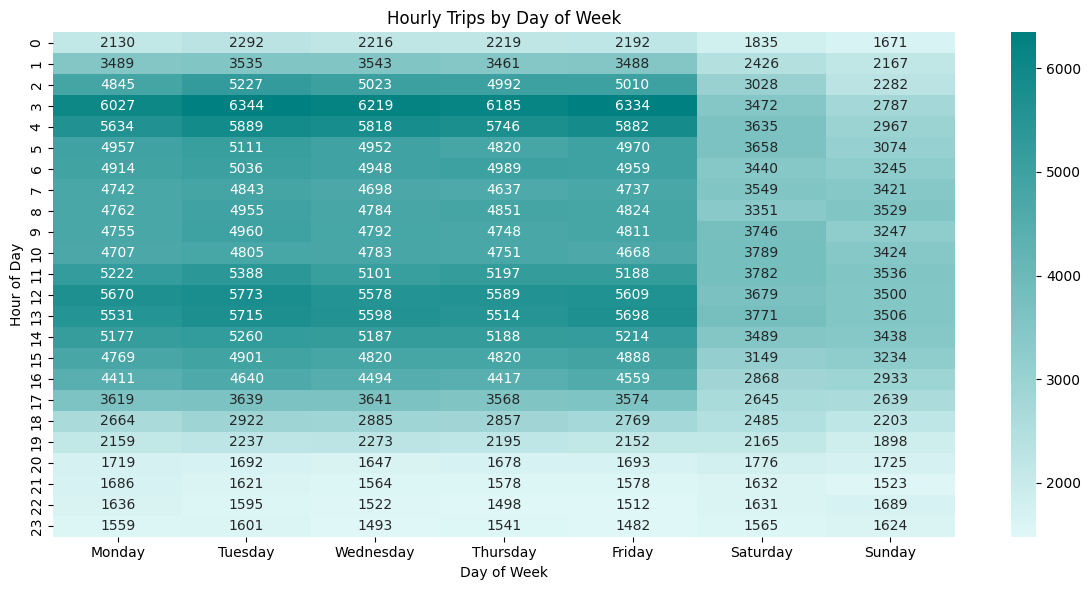

In [11]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# Extract day name and hour
all_trips['pickup_day'] = all_trips['start_time'].dt.day_name()
all_trips['pickup_hour'] = all_trips['start_time'].dt.hour

# Create hourly matrix: hours as rows, days as columns
hourly_matrix = all_trips.groupby(['pickup_hour', 'pickup_day']).size().unstack().fillna(0).astype(int)

# Optional: reorder columns to match weekday order
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_matrix = hourly_matrix[ordered_days]

# Plot heatmap
plt.figure(figsize=(12, 6))
# Define a custom teal colormap
teal_cmap = LinearSegmentedColormap.from_list("teal_cmap", ["#e0f7f7", "#008080"])
sns.heatmap(hourly_matrix, cmap=teal_cmap, annot=True, fmt='d', cbar=True)

# Labels and title
plt.title('Hourly Trips by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()

🟦 Stops Distribution on the NYC Map

In [21]:
import folium
# Load the stops file
stops_df = pd.read_csv(r"C:\Users\ahmed.mabdullah\Desktop\GUC\Capstone Project\Subway_data\2024 Subway\gtfs_Subway\stops.txt")

# Create a base NYC map centered around NYC coordinates
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Plot each stop as a marker
for _, row in stops_df.iterrows():
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=2,
        popup=row['stop_name'],
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(nyc_map)

# Save the map to an HTML file
nyc_map.save("nyc_subway_stops_map.html")

display(nyc_map)

🟦 Top 5 Trips Exceeding 24 Hours Duration

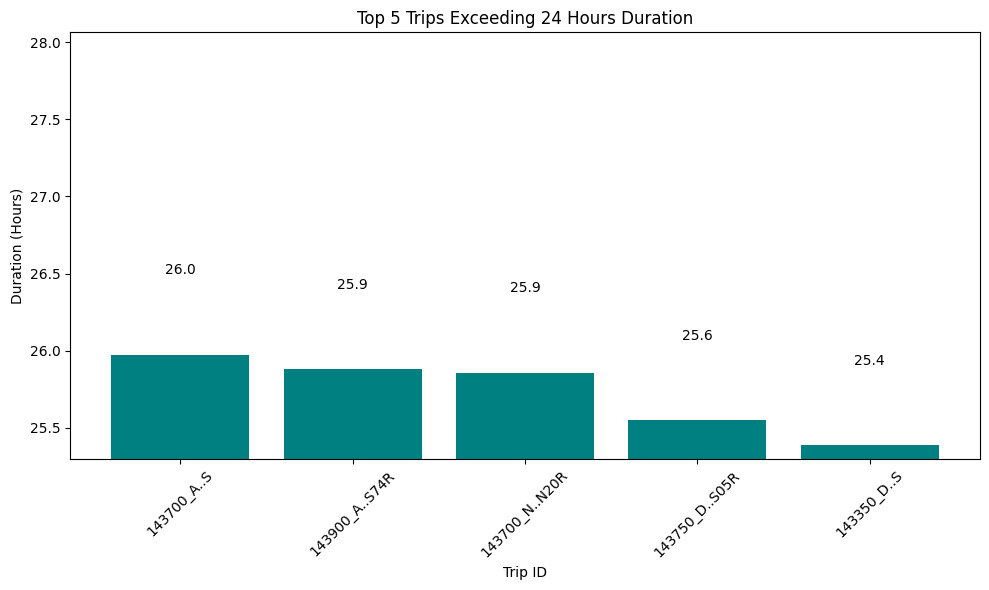

In [ ]:
import matplotlib.pyplot as plt

# Filter trips that exceeded 24 hours
long_trips = all_trips[all_trips['trip_duration_hours'] > 24]

# Sort and get top 5 longest trips
top_5_long_trips = long_trips.sort_values(by='trip_duration_hours', ascending=False).head(5)

# Plot setup using Axes object
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    top_5_long_trips['trip_id'].astype(str), 
    top_5_long_trips['trip_duration_hours'], 
    color='teal'
)

# Annotate each bar with its height (duration)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.1f}', 
            ha='center', va='bottom', fontsize=10)

# Set chart titles and labels
ax.set_title('Top 5 Trips Exceeding 24 Hours Duration')
ax.set_xlabel('Trip ID')
ax.set_ylabel('Duration (Hours)')
ax.set_xticks(range(len(top_5_long_trips)))
ax.set_xticklabels(top_5_long_trips['trip_id'].astype(str), rotation=45)

# Adjust y-axis to zoom in and fit text properly
min_count = top_5_long_trips['trip_duration_hours'].min()
max_count = top_5_long_trips['trip_duration_hours'].max()
margin = (max_count - min_count) * 0.15  # increased to 15% top margin

# Ensure some padding above tallest bar for annotations
ax.set_ylim(min_count - margin, max_count + margin + 2)

# Final layout and show plot
plt.tight_layout()
plt.show()
